**Workflow**

1. query_rotd50.sql: query sites, output "Northridge_sites.txt"
2. query_events.sql: query events, output "northridge_events.txt"
3. retrieve_seismogram.py: cp sits and events files to intensity.usc.edu, run python script to retrieve ssmgrms, then scp back
4. nr=NR(num); nr.gen_events(): generate "num" of events, read records from "Northridge_records.txt"  
    4.1. nr.stf()[i].load_pgv_and_pga  
    4.2. nr.stf()[i].load_psa
5. nr.load_avg_metrics()

In [32]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import mysql.connector
import subprocess
import sys
import os
import re
import struct
import collections
import pickle
from pathlib import Path

import matplotlib.colors as mcolors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


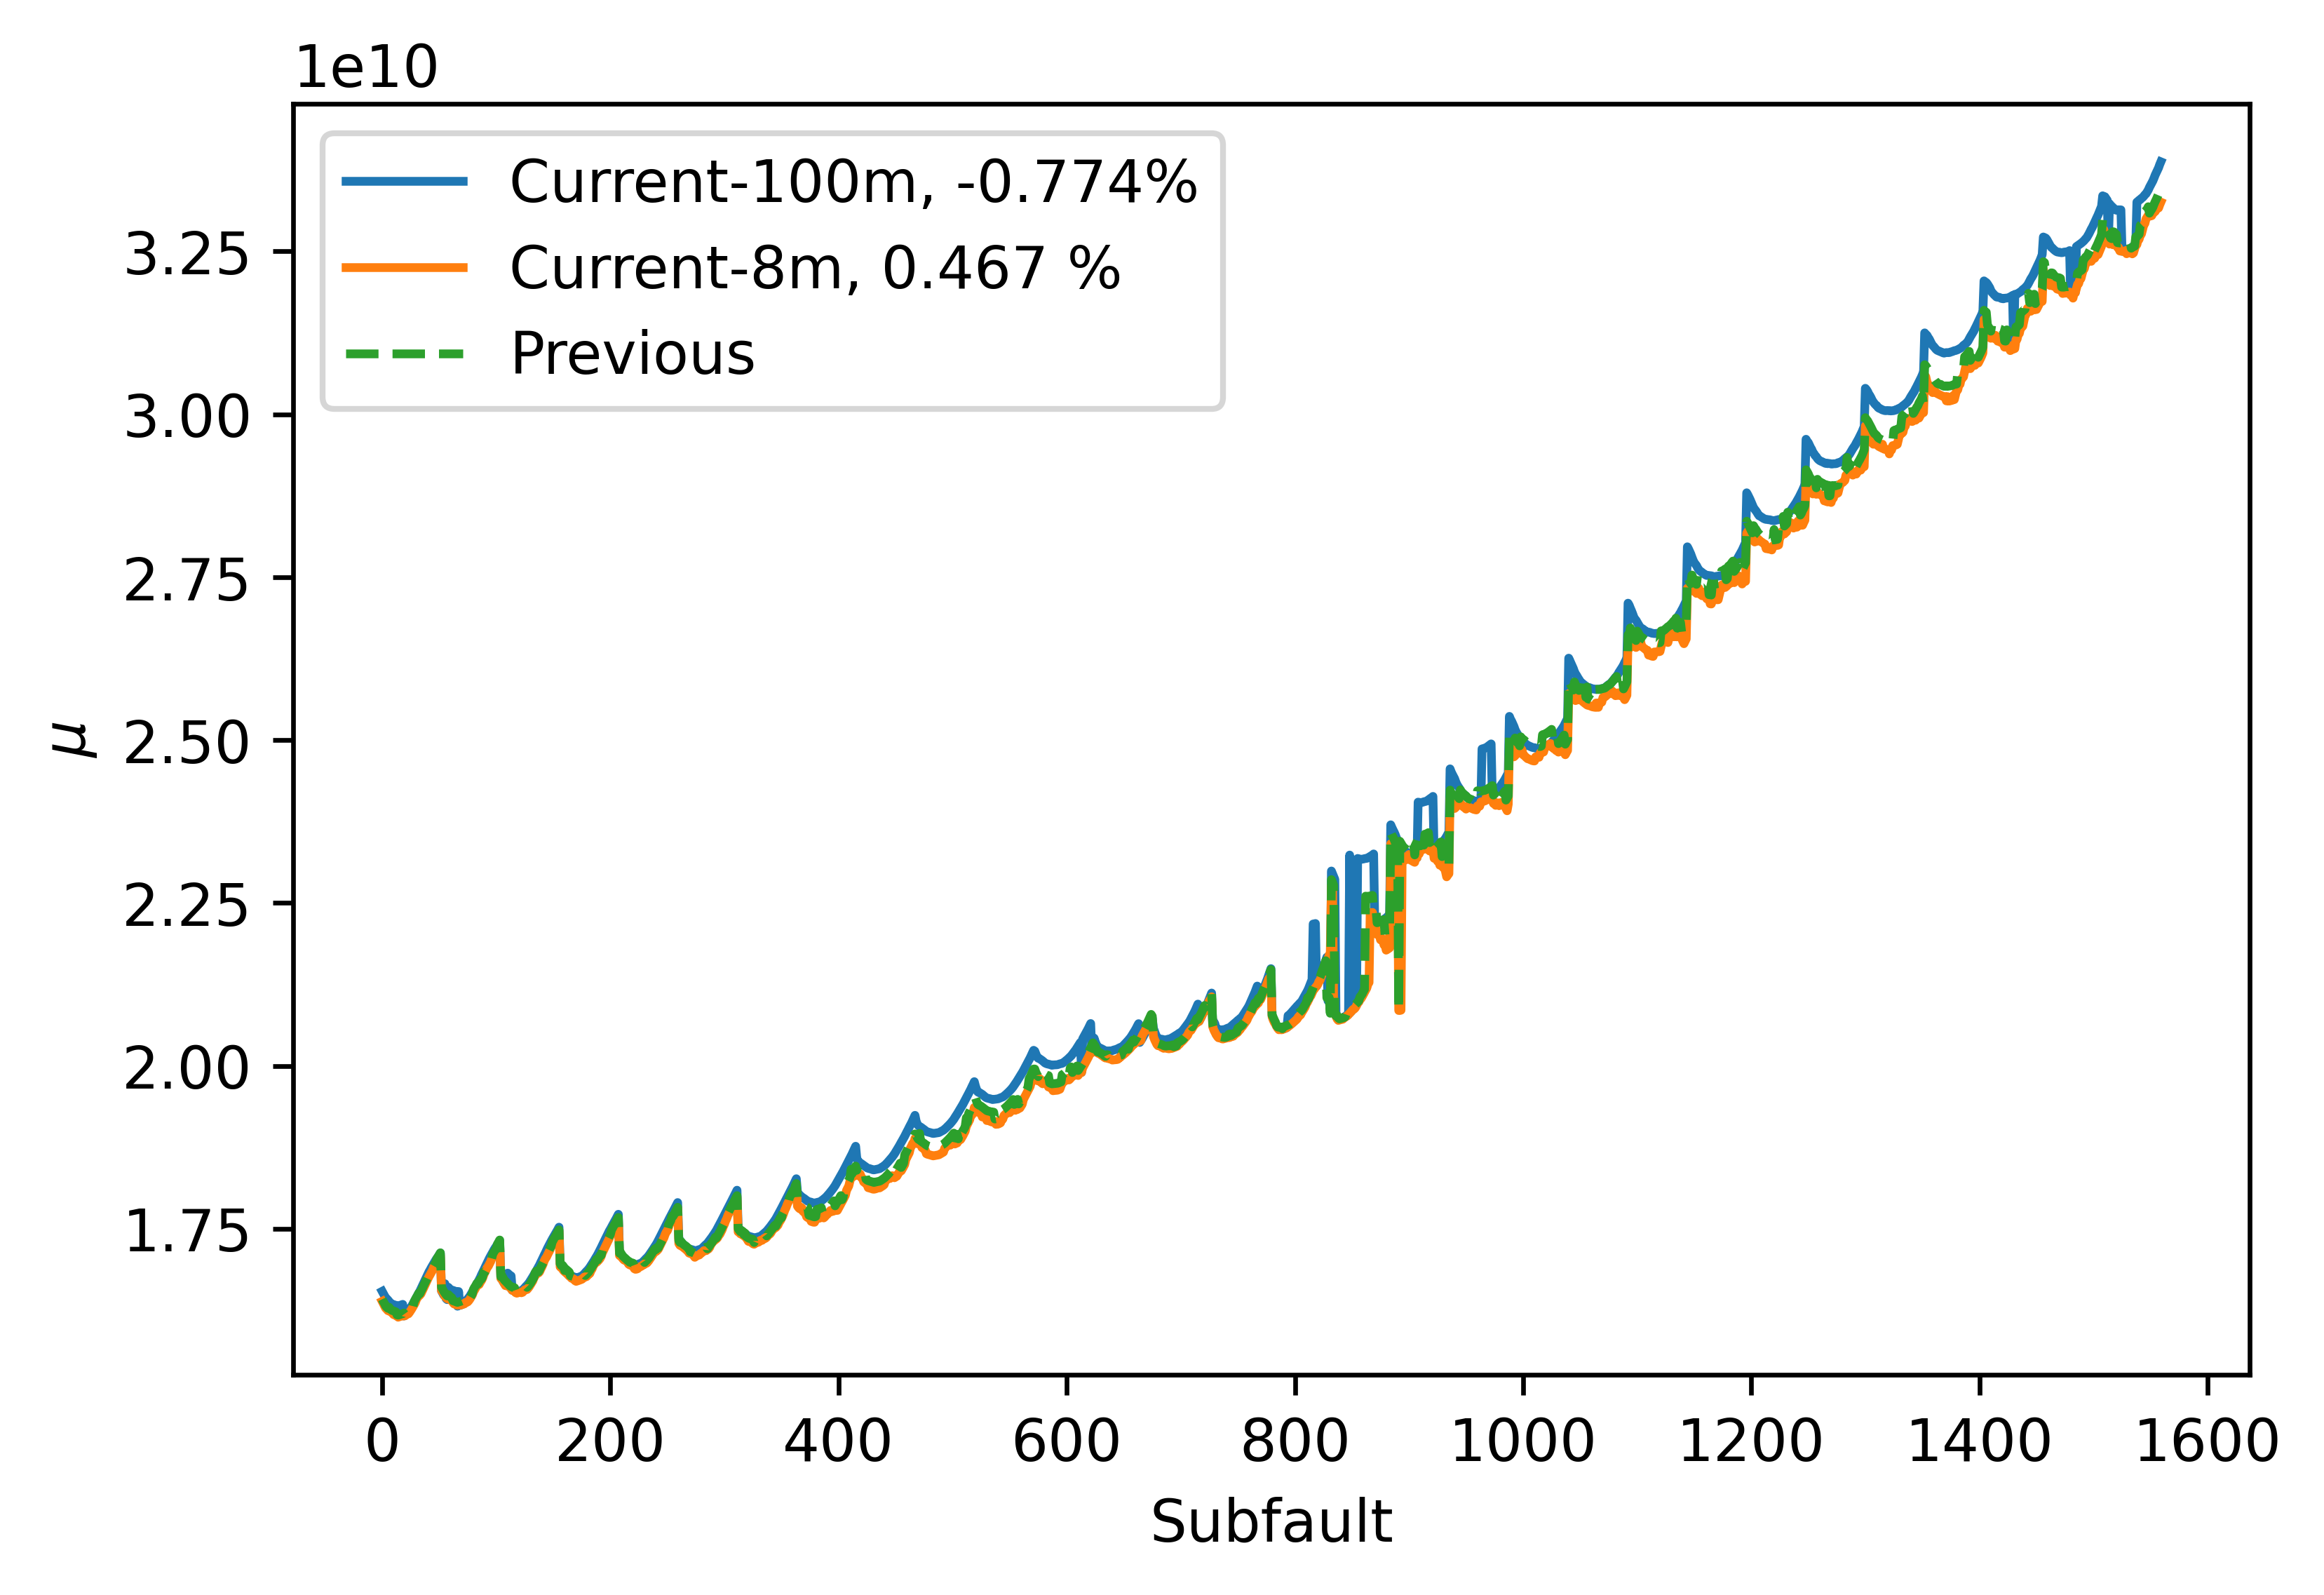

In [49]:
mu0 = np.genfromtxt('/ccs/home/hzfmer/scratch/high_f/toy/subfaults.idx', usecols=4)
mu1 = np.genfromtxt('/ccs/home/hzfmer/scratch/high_f/toy/subfaults_8m.idx', usecols=4)
mu2 = np.genfromtxt('/ccs/home/hzfmer/scratch/high_f/toy/100m_lat_lon_mu.txt', usecols=3)
fig, ax = plt.subplots(dpi=600)
ax.plot(mu0, label=f'Current-100m, {np.mean((mu2 - mu0) / mu0) * 100:.3f}%')
ax.plot(mu1, label=f'Current-8m, {np.mean((mu2 - mu1) / mu1) * 100:.3f} %')
ax.plot(mu2, label='Previous', ls='--')
ax.set(xlabel='Subfault', ylabel='$\mu$')
ax.legend()
#ax.set_title(f'Average difference = {np.mean((mu2 - mu1) / mu1) * 100:.3f} %')

## Subroutines

In [3]:
def call_sub(cmd, shell=False):
    p = subprocess.run(cmd, shell=shell, capture_output=True)
    if p.stderr:
        print("Error\n", p)
    return p

#cmd = ['module swap xl gcc']
#cmd = ['module load fftw/3.3.5']
#cmd = ['export LD_LIBRARY_PATH=/gpfs/alpine/proj-shared/geo112/CyberShake/utils/libmemcached_1.0.18/lib:$LD_LIBRARY_PATH']

def call_mysql(cmd):
    conn = mysql.connector.connect(host='focal.usc.edu', user='cybershk_ro',
                                   password='CyberShake2007',
                                   database='CyberShake',
                                   use_unicode=True)
    cursor = conn.cursor()
    cursor.execute(cmd)
    return cursor.fetchall()


def create_srf(src_id, rup_id, rup_var_id):
    '''
    Call subroutine "create_srfs" to generate SRF files.
    Has to be done on Summit
    
    Prepare
    -------
        export LD_LIBRARY_PATH=/gpfs/alpine/proj-shared/geo112/CyberShake/utils/libmemcached_1.0.18/lib:$LD_LIBRARY_PATH
        module load fftw
    '''
    cmd = ['./create_srfs', str(src_id), str(rup_id), str(rup_var_id), str(rup_var_id + 1)]
    print(cmd)
    call_sub(cmd)
    
    
def comp_dist(lon1, lat1, lon0=-118.537, lat0=34.213):
    '''Compute distance to hypocenter (-118.537, 34.213)
    '''
    # 110.9: one degree of latitude in km
    # 92.2: one degree of longitude in km at (-118.537E, 34.213N)
    return np.sqrt((110.9 * (lat1 - lat0)) ** 2 + (92.2 * (lon1 - lon0)) ** 2)

def is_float(x):
    try:
        x = float(x)
        x = int(x) if x.is_integer() else x
    except ValueError:
        pass
    return x

def read_sql_output(fname, split=True):
    with open(fname, 'r') as fid:
        fid.readline()  # Skip header
        res = fid.readlines()
    if split:
        res = [list(map(is_float, r.strip().split())) for r in res]
    return res

def force_iterable(x):
    return x if isinstance(x, collections.abc.Iterable) or isinstance(x, str) else [x]

## NR (Northridge) class

In [23]:
class NR():
    """Northeidge scenario
    
    Parameters
    ----------
        lon, lat, dep, meg : float
            focal information for the 2014 M6.6 Northridge earthquake
        
    """
    def __init__(self,  num=10):
        self.lon = -118.537
        self.lat = 34.213
        self.dep = 18.2
        self.mag = 6.7
        self.num = num  # The number of events to query
        self.sites = read_sql_output('Northridge_sites.txt')
        self.dist = [comp_dist(float(site[1]), float(site[2])) for site in self.sites]   
        self.misfit = collections.defaultdict(lambda: collections.defaultdict(float))
        self.metric_ratio = collections.defaultdict(lambda: collections.defaultdict(float))
        self.best_stf_idx = collections.defaultdict(lambda: float('inf'))
        self.best_stf = collections.defaultdict(lambda: None)
        self.worst_stf_idx = collections.defaultdict(lambda: float('-inf'))
        self.worst_stf = collections.defaultdict(lambda: None)
        self.load_events()
        self.load_records()
            
    def _query_events(self):
        
        cmd = (f'select V.Source_ID, V.Rupture_ID, V.Rup_Var_ID, R.Mag, '
               f'sqrt(110.9*110.9*(V.Hypocenter_Lat-{self.lat})*(V.Hypocenter_Lat-{self.lat})'
               f'+92.2*92.2*(V.Hypocenter_Lon-{self.lon})*(V.Hypocenter_Lon-{self.lon})'
               f'+(V.Hypocenter_Depth-{self.dep})*(V.Hypocenter_depth-{self.dep})) '
               f'from Rupture_Variations V, Ruptures R '
               f'where R.Source_ID=V.Source_ID and R.Rupture_ID=V.Rupture_ID and R.ERF_ID=36 '
               f'and R.ERF_ID=V.ERF_ID and V.Rup_Var_Scenario_ID=6 and R.Source_Name="Northridge" '
               f'and R.Mag>{self.mag - 0.1} and R.Mag<{self.mag + 0.1} '
               f'order by sqrt(110.9*110.9*(V.Hypocenter_Lat-{self.lat})*(V.Hypocenter_Lat-{self.lat})'
               f'+92.2*92.2*(V.Hypocenter_Lon-{self.lon})*(V.Hypocenter_Lon-{self.lon})+'
               f'(V.Hypocenter_Depth-{self.dep})*(V.Hypocenter_depth-{self.dep})) asc limit {self.num};')
        self.events = sorted(call_mysql(cmd), key=lambda k: k[-1])  # Sort based on distance
        return self.events

    
    def load_events(self):
        try:
            self.events = read_sql_output('Northridge_events.txt')
        except Exception:
            self._query_events()
            
            
    def gen_stfs(self, plot=False):
        self.stf = {}
        for i, e in enumerate(self.events):
            self.stf[i] = STF(e[0], e[1], e[2])
            if plot:
                self.stf[i].plot_stf(save=True)
    
    def _query_records(self):
        self.records = collections.defaultdict(list)
        keys = ['name', 'id', 'lat', 'lon', 'dist', 'pga', 'pgv', 'psa03', 'psa10', 'psa30']
        with open('Northridge_records.txt', 'r') as fid:
            for _ in range(15):  # Skip headers
                fid.readline()
            for line in fid:
                if len(line) < 30:  # Skip tails of HTML, generated by wget
                    break
                line = re.sub(r'\(.*\)', '', line)  # Delete brackets and the contents within brackets
                name, number = line[3:14].split()  # The first two items
                lat, lon, dist, pga1, pga2, pgv, _, psa03, psa10, psa30, _ = \
                    map(float, line[55:].replace('- -', '-').replace('-', '0').split())
                # dist = re.search('.*(?=\()', dist).group(0)
                pga = np.sqrt(pga1 ** 2 + pga2 ** 2) / 2
                values = [name, number, lat, lon, dist, pga, pgv, psa03, psa10, psa30]
                for key, value in zip(keys, values):
                    self.records[key].append(value)
                    
            for metric in ['pgv', 'pga', 'psa03', 'psa10', 'psa30']:
                # lon should be negative
                lat, lon, rec = zip(*list((lat, -lon, r) for (lat, lon, r) \
                                          in zip(self.records['lat'], self.records['lon'],
                                                 self.records[metric]) if r > 0))
                with open(f'records_{metric}.txt', 'w') as fid:
                    np.savetxt(fid, np.stack((lon, lat, rec), axis=-1), fmt='%.6f', delimiter=' ', newline='\n')

            with open('records.pickle', 'wb') as fid:
                pickle.dump(self.records, fid)
                    
                    
    def load_records(self):
        try:
            self.records = pickle.load(open('records.pickle', 'rb'))
        except OSError:
            self._query_records()
            
            
    def load_avg_metrics(self, metrics=['pga', 'pgv', 'psa05', 'psa10', 'psa30']):
        self.metric_max = collections.defaultdict(float)
        self.metric_min = collections.defaultdict(lambda: float('inf'))
        self.metric = {}
        for s in self.stf.values():
            s.load_psa()
            s.load_pgv_and_pga()    
        
        for m in metrics:
            self.metric_min[m] = np.min([np.min(s.metric[m]) for s in self.stf.values()])
            self.metric_max[m] = np.max([np.max(s.metric[m]) for s in self.stf.values()])
            try:
                self.metric[m] = np.genfromtxt(f'avg_{m}.txt', dtype='float32')[:, -1]
            except IOError:
                self.metric[m] = np.genfromtxt(f'{self.stf[0].case}_{m}.txt', dtype='float32')
                self.metric[m][:, -1] = np.mean(np.vstack([s.metric[m] for s in self.stf.values()]), axis=0)
                np.savetxt(f'avg_{m}.txt', self.metric[m], fmt='%.7f', delimiter=' ')
               
            
    def prepare_cs_metric(self, metric='pgv'):
        """Sort CS metric data by distance

        Returns
        -------
        mean_data : list of float
            Average of multiple scenarios at each site
        max_data 
        min_data
        """

        data = np.zeros((len(self.events), len(self.sites)), dtype='float32')
        idx = np.argsort(self.dist)
        min_diff = float('inf')
        max_diff = float('-inf')
        
        for i, s in self.stf.items():
            data[i, :] = np.take(s.metric[metric], idx)
            if metric in self.records:
                self.misfit[i][metric], self.metric_ratio[i][metric] \
                    = self.comp_diff(metric, data[i, :])
    #                 print(f'STF-[{i}]: {self.stf[i].case}, difference={self.misfit[i][metric]:.3f} '
    #                       f'ratio = {self.metric_ratio[i][metric]:.3f}')
    
                if self.misfit[i][metric] < min_diff:
                    self.best_stf_idx[metric] = i
                    self.best_stf[metric] = s
                    min_diff = self.misfit[i][metric]
                    
                if self.misfit[i][metric] > max_diff:
                    self.worst_stf_idx[metric] = i
                    self.worst_stf[metric] = s
                    max_diff = self.misfit[i][metric]
                    
                self.misfit[len(self.stf)][metric], self.metric_ratio[len(self.stf)][metric] \
                    = self.comp_diff(metric, np.mean(data, axis=0))
    #         print(f"The best-match stf for {metric} is STF-{self.best_stf_idx[metric]}:"
    #               f" {self.best_stf[metric] and self.best_stf[metric].case}")
        return data
    
        
    def comp_diff(self, metric, cs_data):
        """Compute difference between CyberShake and Recordings

        """
        cs_dist = sorted(self.dist)  
        
        # r > 0: avoid empty records
        dist, rec = zip(*list((d, r) for d, r in zip(self.records['dist'], self.records[metric]) if r > 0))
        
        # A simple 1d interpolation, maybe 2d is better, but too costly
        cs = np.interp(dist, cs_dist, cs_data)
        diff = np.sqrt(sum((x - y) ** 2 for (x, y) in zip(cs, rec)))  # least squares
        ratio = np.mean([x / y for (x, y) in zip(cs, rec)])
        return diff, ratio
    
    def plot_metric(self, metric='pgv', save=False):
        '''Plot range of metric along all sites
        Input:
            metirc (str):  ['pgv', 'pga', 'psa30', 'psa10', 'psa05']
        '''
        ylabels = {'pgv': 'PGV (cm/s)', 'pga': 'PGA (g)', 'psa30': 'PSA-3s (g)',
                   'psa10': 'PSA-1s (g)', 'psa05': 'PSA-0.5s (g)'}
        colors = list(mcolors.TABLEAU_COLORS.keys())
        dist = sorted(self.dist)
        data = self.prepare_cs_metric(metric=metric)  # data.shape = (len(nr.events), len(nr.sites))
        mean_data = np.mean(data, axis=0)
        max_data = np.max(data, axis=0)
        min_data = np.min(data, axis=0)
        
        # Disperse the dots
        idx = np.append(np.arange(len(dist) // 5), np.arange(len(dist) // 5, len(dist), 8))
        fig, ax = plt.subplots(dpi=400)
        # ax.plot(np.take(dist, idx), np.take(mean_data, idx), 'r', label='CS-Average')
        ax.fill_between(np.take(dist, idx), np.take(min_data, idx), np.take(max_data, idx),
                        color='gray', alpha=0.25, label='CS-Range')

        # plot average metric from different sources
#         src = collections.defaultdict(list)
#         for i in range(len(self.stf)):
#             src[self.stf[i].src_id].append(i)
#         for j, (k, v) in enumerate(src.items()):
#             ax.scatter(np.take(dist, idx), np.mean(data[np.ix_(v, idx)], axis=0),
#                     c=colors[j + 1], s=10, label=f'src_id={k}')
            
        # plot dots from all sources and best/worst fit
#         src = {}
        for i in range(len(self.stf)):
#             if self.stf[i].src_id not in src: 
#                 src[self.stf[i].src_id] = len(src) + 1
#                 print_label = True
#             else:
#                 print_label = False
#             ax.scatter(np.take(dist, idx), np.take(data[i, :], idx), s=2,
#                        c=colors[src[self.stf[i].src_id]],
#                        label=f'{self.stf[i].src_id}' if print_label else None)
            if i == self.best_stf_idx[metric]:
                ax.scatter(np.take(dist, idx), np.take(data[i, :], idx), s=6,
                       c=colors[1], label=f'CS-Bestfit({i + 1})')
                
            if i == self.worst_stf_idx[metric]:
                ax.scatter(np.take(dist, idx), np.take(data[i, :], idx), s=6,
                       c=colors[2], label=f'CS-Worstfit({i + 1})')

        if metric in self.records:
            rec_dist, rec = zip(*list((d, r) for d, r in zip(self.records['dist'], self.records[metric]) if r > 0))
            ax.scatter(rec_dist, rec, s=6, c=colors[0], marker='*', label='Records')

        ax.set(xlabel=r'$R_{epic}$ (km)', ylabel=fr'${ylabels[metric]}$', xscale='log', yscale='log')
        ax.set_xlim(3, 150)
        ax.legend(loc=1)
        if save:
            fig.savefig(f'{metric}_fit_repic.png', dpi=600, bbox_inches='tight', pad_inches=0.05)
        return fig, ax

## Seismogram class

In [24]:
# %load plot_N_seis.py
'''struct seisheader {
  char version[8];
  char site_name[8];
  //in case we think of something later
  char padding[8];
  int source_id;
  int rupture_id;
  int rup_var_id;
  float dt;
  int nt;
  int comps;
  float det_max_freq;
  float stoch_max_freq;
  };'''

class Seismogram:
    
    def __init__(self, filename):
        # Seismogram_s307_4505_223_5_18.grm
        self.filename = filename
        self.label = "_".join(filename.split('.')[0].split('_')[3:])
        self.nt = 0
        self.dt = 0.0

    def createTimesteps(self):
        self.timesteps = np.arange(self.nt) * self.dt

    def parseHeader(self, header_str):
        #dt is bytes 36-40, nt is 40-44
        self.dt = struct.unpack("f", header_str[36:40])[0]
        self.nt = struct.unpack("i", header_str[40:44])[0]
        #print('Using nt=%d, dt=%f for file %s' % (self.nt, self.dt, self.filename))
        
    def readData(self, _dir="seismograms"):
        '''Read unfiltered seismograms from file
        Components:
            pgv: in cm/s
            pga: in g
            x_data: vx in cm/s
            y_data: vy in cm/s
        '''
        with open(Path(_dir, self.filename), "rb") as fp_in:
            header_str = fp_in.read(56)
            self.parseHeader(header_str)
            data_str = fp_in.read(4 * self.nt)
            self.x_data = np.frombuffer(data_str, dtype='float32')  # cm/s
            #self.x_data = struct.unpack("%df" % self.nt, data_str)
            data_str = fp_in.read(4 * self.nt)
            self.y_data = np.frombuffer(data_str, dtype='float32')  # cm/s
            #self.y_data = struct.unpack("%df" % self.nt, data_str)       
            self.pgv = np.sqrt(np.max(self.x_data ** 2 + self.y_data ** 2))
            self.pga = np.sqrt(np.max(np.gradient(self.x_data, self.dt) ** 2 +
                                      np.gradient(self.y_data, self.dt) ** 2)) / 980  # cm/s --> g

### Plot seismograms
Select 10 sites with increasing distance to the hypocenter, plotting seismograms at each site for all 10 scenarios

In [25]:
def sample_sites():
    '''Randomly select 10 sites for seismograms plotting
    DO NOT TRY TO REPRODUCE THE RESULTS.
    This function relies on random functions, so the return can vary at each run.
    '''
    sites = read_sql_output('Northridge_sites.txt')
    
    dist = np.zeros(len(sites))
    for i, s in enumerate(sites):
        dist[i] = comp_dist(float(s[1]), float(s[2]))

    indices = np.arange(len(sites))
    indices, dist = zip(*sorted(zip(indices, dist), key=lambda v:v[1]))
    print(f'Sites sorted according to distance to the hypocenter.')

    choices = [len(sites) // i for i in [len(sites) + 1, 60, 20, 9, 3, 1]]
    res = []
    with open('Northridge_10sites.txt', 'w') as fid:
        fid.write('CS_Short_Name CS_Site_Lat CS_Site_Lon Run_ID\n')
        for i in range(1, len(choices)):
            idx = np.random.choice(range(choices[i - 1], choices[i]), 2, replace=False)
            print(f'Indices of the sites selected: {idx}')
            for i in idx:
                print(f'Distance to the hypocenter: {dist[i]:.2f}')
                fid.write(sites[indices[i]])
                res.append(sites[indices[i]])
    return res
                      
     
def get_seismograms(site, events):
    '''Read_seismograms at one site from multiple events
    Input:
        site (list): [[site_name, lon, lat, run_id]...]
        events (list): [[source_id, rupture_id, rup_var_id, mag, dist]...]
    Output:
        seismograms (list): [Seismogram]
    '''
    run_id = int(site[3])
    site_name = site[0]
    seismograms = []
    # Example format: Seismogram_s307_4505_223_5_18.grm
    for event in events:
        source_id, rupture_id, rup_var_id = (int(e) for e in event[:3])
        fname = f'Seismogram_{site_name}_{run_id}_{source_id}_{rupture_id}_{rup_var_id}.grm'
        seismograms.append(Seismogram(fname))
    return seismograms
    
def plot_seismograms(site, events, vp=3.8, last=30):
    seismograms = get_seismograms(site, events)   
    
    dist = comp_dist(float(site[1]), float(site[2]))
    dx = dy = 0
    ratio = 2.2
    for seis in seismograms:
        seis.readData()
        seis.createTimesteps()
        dx = np.mean((dx, ratio * np.max(seis.x_data))) if dx else ratio * np.max(seis.x_data)
        dy = np.mean((dy, ratio * np.max(seis.y_data))) if dy else ratio * np.max(seis.y_data)
        
    fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=400)
    fig.suptitle(f'Site {site_name}, Rhypo={dist:.2f} km', y=1.08)
    fig.tight_layout()
    for i, seis in enumerate(seismograms):
        ax[0].plot(seis.timesteps, seis.x_data - i * dx, label=seis.label)
        ax[0].annotate(f'{np.max(seis.x_data):.4f}', (dist/vp, seis.x_data[0] - i * dx), xytext=(-3, 0),
                       textcoords='offset points', ha='right', va='center')
        ax[1].plot(seis.timesteps, seis.y_data - i * dy, label=seis.label)
        ax[1].annotate(f'{np.max(seis.y_data):.4f}', (dist/vp, seis.y_data[0] - i * dy), xytext=(-3, 0),
                       textcoords='offset points', ha='right', va='center')
    
    ax[0].set(xlim=(dist/vp, dist/vp + last), xlabel='Time (s)', title="X component (m/s)", yticks=[], yticklabels=[])
    ax[1].set(xlim=(dist/vp, dist/vp + last), xlabel='Time (s)', title="Y component (m/s)", yticks=[], yticklabels=[])
    ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=plt.gcf().transFigure,
                 fancybox=True)
    fig.savefig(f"seismogram_{site_name}_10events.png", bbox_inches='tight', pad_inches=0.05)
    return fig

def call_plot_seismograms():
    try:
        # Components:  CS_Short_Name CS_Site_Lon CS_Site_Lat Run_ID     
        sites = read_sql_output('Northridge_10sites.txt')
    except Exception as e:
        sites = sample_sites()

    # Components:  Source_ID Rupture_ID  Rup_Var_ID  Mag Dist
    events = read_sql_output('Northridge_events.txt')
    for site in sites:
        fig = plot_seismograms(site, events)
    
    return fig

#call_plot_seismograms()

## STF class

In [26]:
class STF(NR):
    '''
    A class of stf generated from the Northridge Earthquake
    '''
    
    def __init__(self, src_id, rup_id, rup_var_id):
        super().__init__()
        self.src_id = src_id
        self.rup_id = rup_id
        self.rup_var_id = rup_var_id
        self.case = f'{src_id}_{rup_id}_{rup_var_id}_uniform'
        self.fsrf = f'{self.case}.srf'
        self.fslip = f'{self.case}_slip.bin'
        self.finit = f'{self.case}_init.bin'       
        if not Path(self.fsrf).exists():
            create_srf(src_id, rup_id, rup_var_id)  
            print("SRF created")
        self.slon, self.slat, self.nx, self.nz, self.dtop = self.read_srf(return_param=True)
        self.dh = 0.2  # dh = 200 m = 0.2 km  
        self.metric = collections.defaultdict(lambda: np.zeros(len(self.sites), dtype='float32'))
        # self.load_psa()
        # self.load_pgv_and_pga()
        
        
    def read_srf(self, return_param=False):
        '''Read SRF file
        Input:
            return_param (Bool): If True, return header information
        
        Output:
            slip (ndarray): Slip on the fault in m
            init (ndarray): Initial rupture time in s
        '''
        f = open(self.fsrf, 'r')
        f.readline()
        f.readline()
        token = f.readline().split()
        slon = float(token[0])
        slat = float(token[1])
        nx = int(token[2])
        nz = int(token[3])
        token = f.readline()
        dtop = float(token.split()[2])
        f.readline()
        
        if return_param:
            return slon, slat, nx, nz, dtop
        
        slip = np.zeros((nz, nx), dtype='float32')
        init = np.zeros((nz, nx), dtype='float32')
        # idx = np.genfromtxt('subfaults.idx')
        # idx = idx[:, : 3].astype('int').reshape(4 * nz *  nx, 3)
        # stf_type = 3.0

        for j in range(nz):
            sys.stdout.write("\rreading subfault %d of %d" % (j+1, nz))
            sys.stdout.flush()
            last_pos = f.tell()
            for i in range(nx):
                nl1 = f.readline().split()
                nl2 = f.readline().split()
                # stk = float(nl1[3]) - theta_rot
                # dip = float(nl1[4])
                # area = float(nl1[5]) / 1.e4  # cm^2 --> m^2
                init[j, i] = float(nl1[6])
                # dt = float(nl1[7])
                # rake = float(nl2[0])
                slip[j, i] = float(nl2[1]) / 1.e2  # cm --> m
                nt1 = int(nl2[2])
                nskip1 = int(np.ceil(nt1 / 6.))
                for l in range(nskip1):
                    f.readline()
                # trise = nt1 * dt
                
        slip.tofile(self.fslip)
        init.tofile(self.finit)
        f.close()
        return slip, init
    
    def read_fault_rupture(self):
        try:
            slip = np.fromfile(self.fslip, dtype='float32').reshape(self.nz, self.nx)
            init = np.fromfile(self.finit, dtype='float32').reshape(self.nz, self.nx)
        except FileNotFoundError:
            slip, init = self.read_srf()
        return slip, init
    
    def plot_stf(self, cmap='YlOrRd', save=False):
        fig, ax = plt.subplots(dpi=600)
        slip, init = self.read_fault_rupture()
        print(slip.shape)
        cax = ax.pcolormesh(np.linspace(0, self.nx * self.dh, self.nx),
                            np.linspace(self.dtop, self.dtop + self.nz * self.dh, self.nz),
                            slip, cmap=cmap)
        ax.contour(np.linspace(0, self.nx * self.dh, self.nx),
                   np.linspace(self.dtop, self.dtop + self.nz * self.dh, self.nz),
                   init, np.arange(np.max(init)), linewidths=0.8, cmap='bone')
        ax.set_xlabel('Along strike (km)', fontsize=10)
        ax.set_ylabel('Along dip (km)', fontsize=10)
        ax.set_title(self.case)
        ax.invert_yaxis()
        cb = plt.colorbar(cax, ax=ax, orientation='horizontal', pad=0.2, aspect=30)
        cb.ax.set_xlabel('Slip (m)', fontsize=10)
        if save:
            fig.savefig(f"{self.case}.png", dpi=600, bbox_inches='tight',
                        pad_inches=0.05)
            
    def _query_psa(self, periods=[3, 1, 0.5]):
        """
        Study_ID = 7, probably Study 15.12 only
        """
        periods = force_iterable(periods)
        IM_ID = {3: 162, 1: 169, 0.5: 173}
        for period in periods:
            if period not in periods:
                print(f'Current periods do not include the queried one {period}')
                return
            with open(f'{self.case}_psa{int(period * 10):02d}.txt', 'w') as fid:
                cmd = f'select s.CS_Site_Lon, s.CS_Site_Lat, p.IM_Value ' \
                      f'from PeakAmplitudes p, CyberShake_Sites s, CyberShake_Runs cr ' \
                      f'where p.Source_ID={self.src_id} and p.Rupture_ID={self.rup_id} ' \
                      f'and p.Rup_Var_ID={self.rup_var_id} and p.IM_Type_ID = {IM_ID[period]} ' \
                      f'and cr.Run_ID=p.Run_ID and cr.Study_ID=7 and s.CS_Site_ID=cr.Site_ID ' \
                      f'order by s.CS_Short_Name;'
                psa = np.array(call_mysql(cmd))
                psa[:, 2] = psa[:, 2] / 980  # cm/s^2 --> g
                np.savetxt(fid, psa, fmt='%.7f', delimiter=' ')
    
    def load_psa(self, periods=[3, 1, 0.5]):
        periods = force_iterable(periods)
        for period in periods:
            # psa30: psa-3s, psa10: psa-1s, psa05: psa-0.5s
            fname = f'{self.case}_psa{int(period * 10):02d}.txt'
            if not Path(fname).exists():
                print(f"File {fname} does not exist, quering!")
                self._query_psa(period)
            self.metric['psa' + f'{int(period * 10):02d}'] = np.genfromtxt(fname)[:,-1]                
             
    def load_pgv_and_pga(self):
        try:
            # Format: lon, lat, pgv/pga
            self.metric['pgv'] = np.genfromtxt(f'{self.case}_pgv.txt', dtype='float32')[:, -1]
            self.metric['pga'] = np.genfromtxt(f'{self.case}_pga.txt', dtype='float32')[:, -1]
        except Exception:
            pgv = np.genfromtxt(f'{self.case}_psa10.txt', dtype='float32')
            pga = np.genfromtxt(f'{self.case}_psa10.txt', dtype='float32')
            for i, site in enumerate(self.sites):
                fname = (f'Seismogram_{site[0]}_{site[-1]}_{self.src_id}_'
                         f'{self.rup_id}_{self.rup_var_id}.grm')
                s = Seismogram(fname)
                s.readData()
                self.metric['pgv'][i] = pgv[i, -1] = s.pgv 
                self.metric['pga'][i] = pga[i, -1] = s.pga
            np.savetxt(f'{self.case}_pgv.txt', pgv, fmt='%.7f', delimiter=' ')
            np.savetxt(f'{self.case}_pga.txt', pga, fmt='%.7f', delimiter=' ')
            
            
    def plot_metrics_GMT(self, periods=[3, 1, 0.5, 0, -1]):
        """
        Use GMT to plot psa map
        
        Input
        -----
            periods : list
                -1 : pgv
                0 : pga
                positive : rotd50
        """
        for period in periods:
            metric = f'psa{int(period * 10):02d}' if period > 0 else ('pga' if period == 0 else 'pgv')
            unit = 'm/s@+2@+' if period >= 0 else 'm/s'
            label = f'SA-{period:.1f}s' if period > 0 else ('PGA' if period == 0 else 'PGV')
            fname = f'{self.case}_{metric}.txt'
            data_min, data_max = np.min(self.metric[metric]), np.max(self.metric[metric])
            print(fname, data_min, data_max)
            interval = data_max / 10
            gmt_cmd = (f'gmt begin {self.case}_{metric} png\n'
                       f'gmt basemap -JM15c -R-119.5/-116/33/35.5 -Baf -BSWen\n'
                       f'gmt makecpt -Crelief -T-3000/3500 -Z\n'
                       f'gmt grdimage @earth_relief_15s -I+d -t30\n'
                       f'gmt colorbar -DjMR+o-1c/0+m -I0.3 -Bxa1000+lElevation -By+lm\n'
                       f'gmt plot -Sa0.7c -Ggreen -l"Northridge"<< EOF\n'
                       f'{self.lon} {self.lat}\n'
                       f'EOF\n'
                       f'gmt plot -Sa0.7c -Glightcyan -l"{self.case}" << EOF\n'
                       f'{self.slon} {self.slat}\n'
                       f'EOF\n'
                       f'gmt makecpt -Cplasma -T0/{data_max} -Z\n'
                       f'gmt plot {fname} -Sc0.2c -C -l"Station"\n'
                       f'gmt colorbar -Bxa{interval:.1f}+l{label} -By+l{unit}\n'            
                       f'gmt end')
            with open('northridge_plot_metric.gmt', 'w') as fid:
                fid.write(gmt_cmd)
            cmd = 'bash northridge_plot_metric.gmt'
            call_sub(cmd, shell=True)
    
            
    def prepare_shakemap(self):
        event_xml = (f'<earthquake id="Northridge_{self.src_id}_{self.rup_id}_'
                     f'{self.rup_var_id}" netid="ci" '
                     f'network="California Integrated Seismic Network" '
                     f'lat="{self.lat}" lon="{self.lon}" depth="{self.dep}" mag="6.8" '
                     f'time="1994-01-17T12:30:55Z" locstring="Northridge, CA" '
                     f'event_type="SCENARIO"/>')
        p = Path('shakemap_events', f'{self.case}')
        p.mkdir(parents=True, exist_ok=True)
        with open(Path(p, "event.xml"), 'w') as fid:
            fid.write(event_xml)

        header = ('<?xml version="1.0" encoding="UTF-8" standalone="yes"?> \n'
                  '<!DOCTYPE earthquake SYSTEM "stationlist.dtd"> \n'
                  '<stationlist created="20300324">'
                  'xmlns="ch.ethz.sed.shakemap.usgs.xml"')
        with open(Path(p, "event_dat.xml"), 'w') as fout:
            fout.write(header + '\n')
            for i, site in enumerate(self.sites):
                text = (f'  <station code="{site[0]}" name="{site[0]}" netid="CI" '
                        f'insttype="" lat="{site[2]}" lon="{site[1]}">\n'
                        f'    <comp name="--.BHE">\n'
                        f'      <pgv value="{self.metric["pgv"][i]:.5f}" flag="0"/>\n'
                        f'      <pga value="{self.metric["pga"][i]:.5f}" flag="0"/>\n'
                        f'      <psa10 value="{self.metric["psa10"][i]*100/9.8:.5f}" flag="0"/>\n'
                        f'      <psa30 value="{self.metric["psa30"][i]*100/9.8:.5f}" flag="0"/>\n'
                        f'    </comp>\n'
                        f'  </station>\n')
                fout.write(text)
            fout.write('</stationlist>')

## Start processing

In [27]:
def read_srf(fsrf):
    '''Read SRF file
    Input:
        return_param (Bool): If True, return header information

    Output:
        slip (ndarray): Slip on the fault in m
        init (ndarray): Initial rupture time in s
    '''
    f = open(fsrf, 'r')
    f.readline()
    f.readline()
    token = f.readline().split()
    slon = float(token[0])
    slat = float(token[1])
    nx = int(token[2])
    nz = int(token[3])
    token = f.readline()
    dtop = float(token.split()[2])
    f.readline()

    print(f'; Strike is {token.split()[0]}; rake is {token.split()[1]}')
    strike = []
    rake = []
    dip = []

    for j in range(nz):
        sys.stdout.write("\rreading subfault %d of %d" % (j+1, nz))
        sys.stdout.flush()
        last_pos = f.tell()
        for i in range(nx):
            nl1 = f.readline().split()
            nl2 = f.readline().split()
            strike += float(nl1[3]),
            dip += float(nl1[4]),
            # area = float(nl1[5]) / 1.e4  # cm^2 --> m^2
            # dt = float(nl1[7])
            rake += float(nl2[0]),
            nt1 = int(nl2[2])
            nskip1 = int(np.ceil(nt1 / 6.))
            for l in range(nskip1):
                f.readline()
            # trise = nt1 * dt

    f.close()
    return np.mean(strike), np.mean(dip), np.mean(rake)

In [28]:
# Instantiate the NR (Northridge) class, with certain "num" events

nr = NR(num=10)
nr.gen_stfs()  # instantiate STF (gp rupture) classes

if 0:
    print("ID   Source_ID   Rup_ID  Rup_Var_ID   Mag      Distance (km)")
    for i, e in enumerate(nr.events):
        print("     ".join([str(i).ljust(2)] + [str(x).rjust(5) for x in e]))

In [29]:
# Write focal mechanisms to txt/excel files

if 0 or not Path('srf_focal_meca.txt').exists():
    with open('srf_focal_meca.txt', 'w') as fid:
        fid.write(f"ID   Source_ID   Rup_ID  Rup_Var_ID  Mag    Distance(km)"
                  f"   strike     dip      rake\n")
        for i, e in enumerate(nr.events):
            stk, dip, rake = read_srf(f'{e[0]}_{e[1]}_{e[2]}_uniform.srf')
            fid.write("     ".join([str(i).ljust(2)] + [str(x)[:5].rjust(5) for x in e]) + "        " + 
                      "    ".join([f'{x:.2f}' for x in [stk, dip, rake]]) + "\n")

# columns = 'ID   Source_ID   Rup_ID  Rup_Var_ID  Mag    Distance(km)    strike     dip      rake'.split()
# print(columns)
# focal = pd.read_csv('srf_focal_meca.txt', skiprows=0, delim_whitespace=True)
# print(focal.columns, len(focal.columns))
# focal.to_csv('srf_focal_meca.csv', index=False, float_format='%.3f')

In [30]:
# nr.stf: [list (STF class)]
for s in nr.stf.values():
    s.load_psa()
    s.load_pgv_and_pga() 
    #s.plot_metrics_GMT()  # On rhea
nr.load_avg_metrics()

### Plot_metric

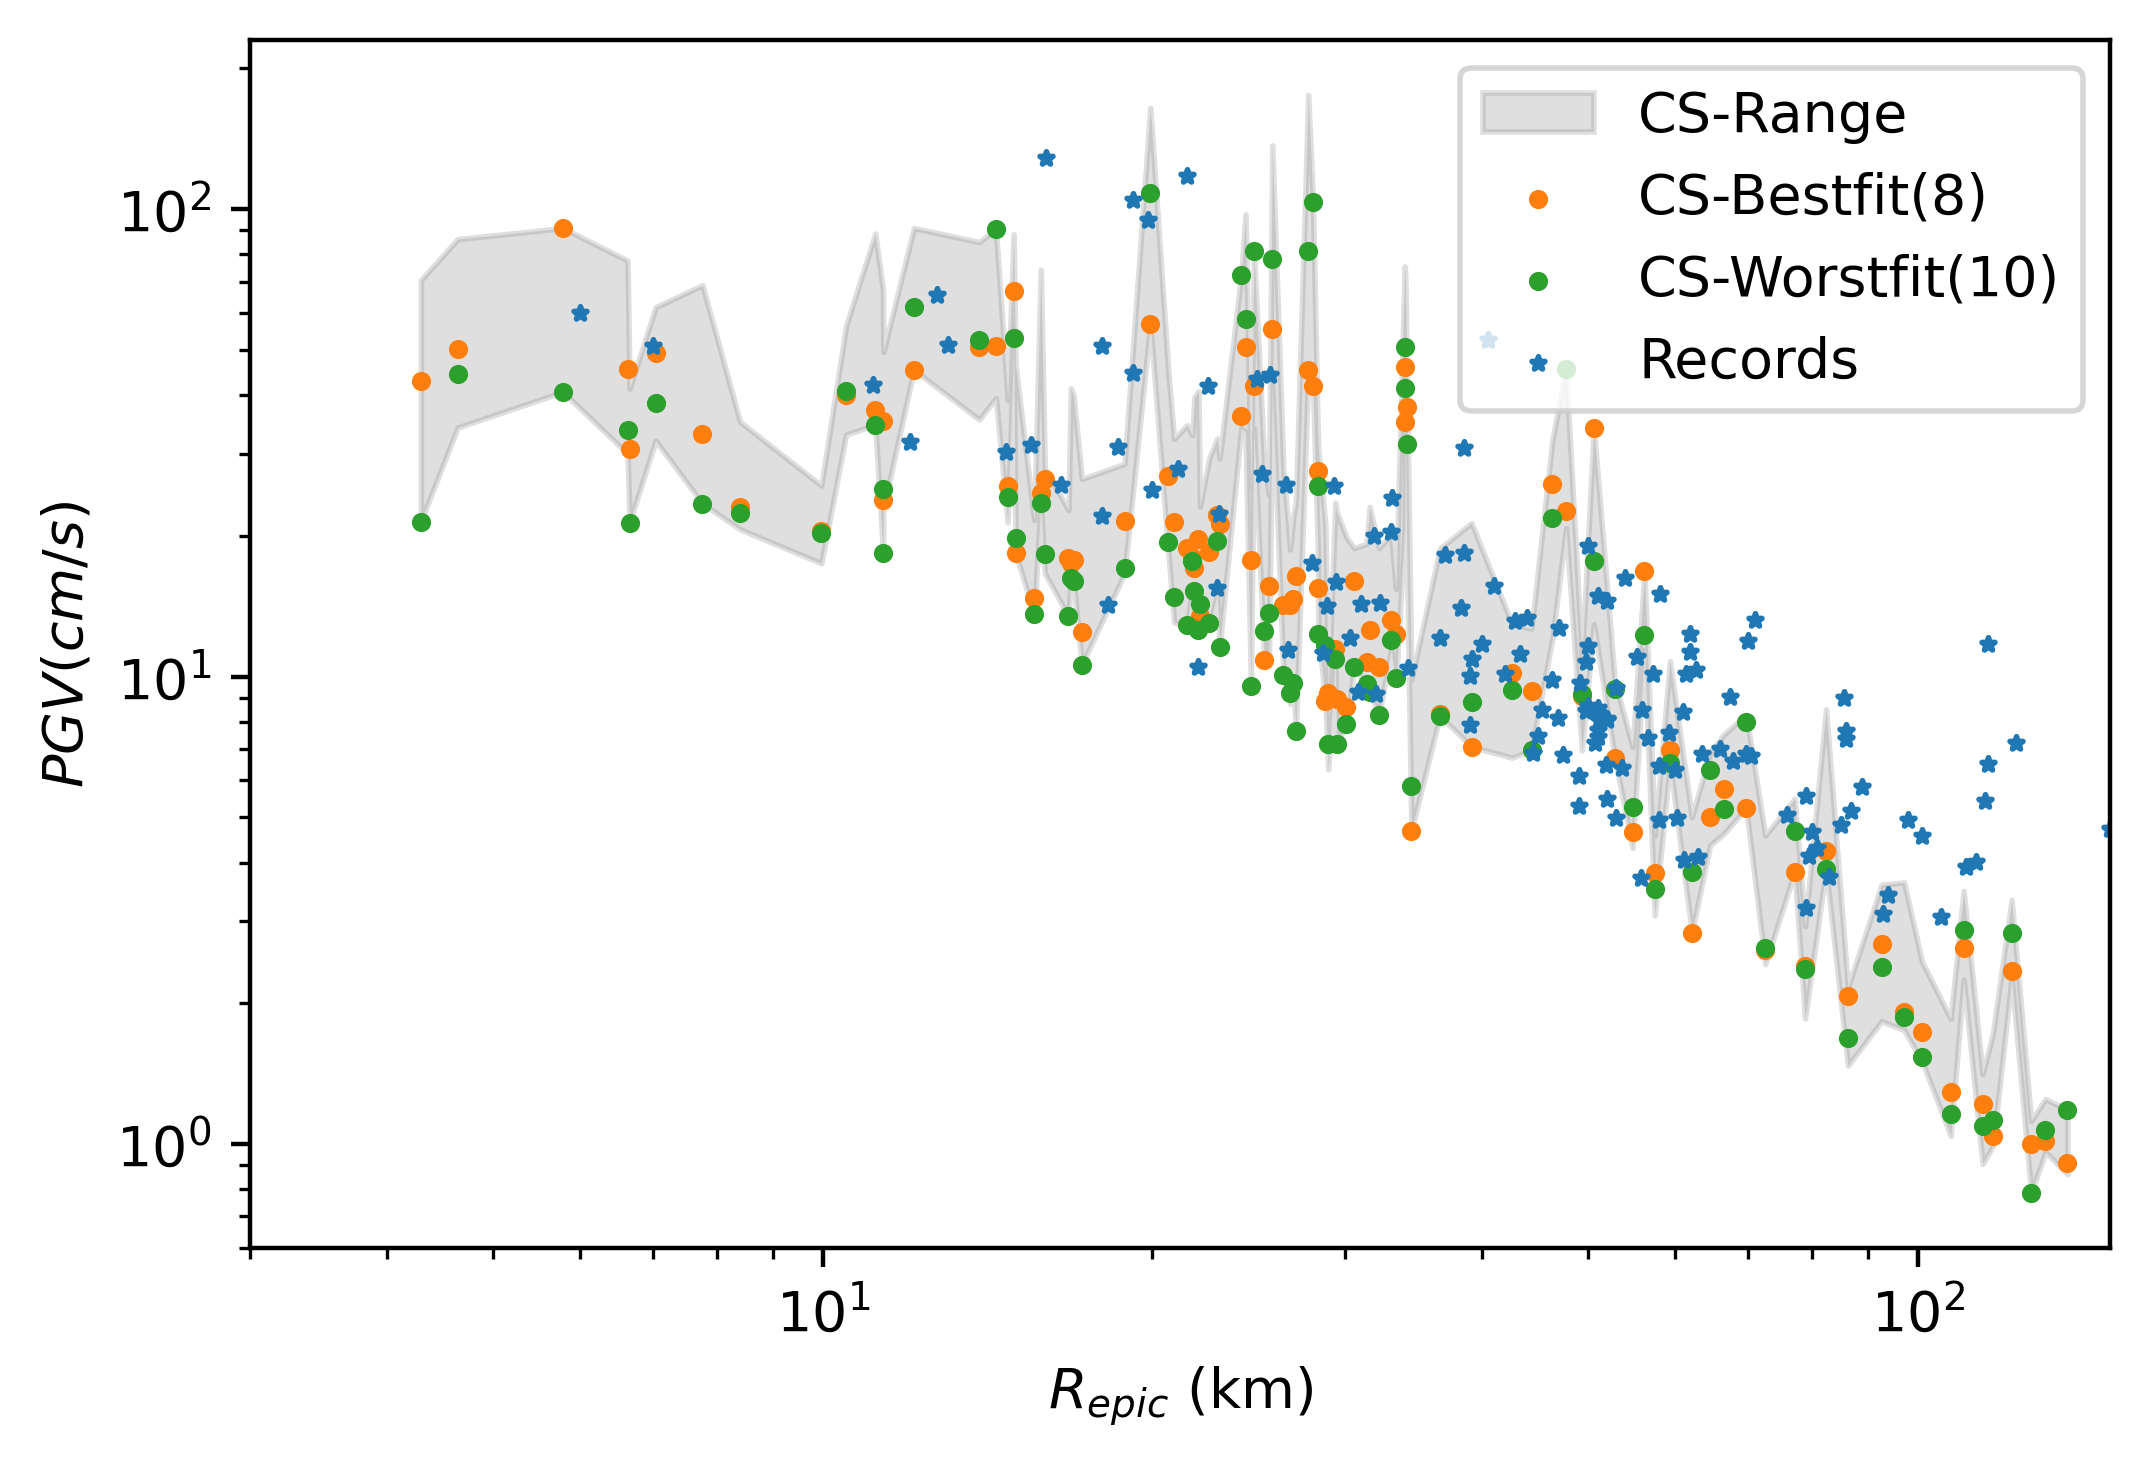

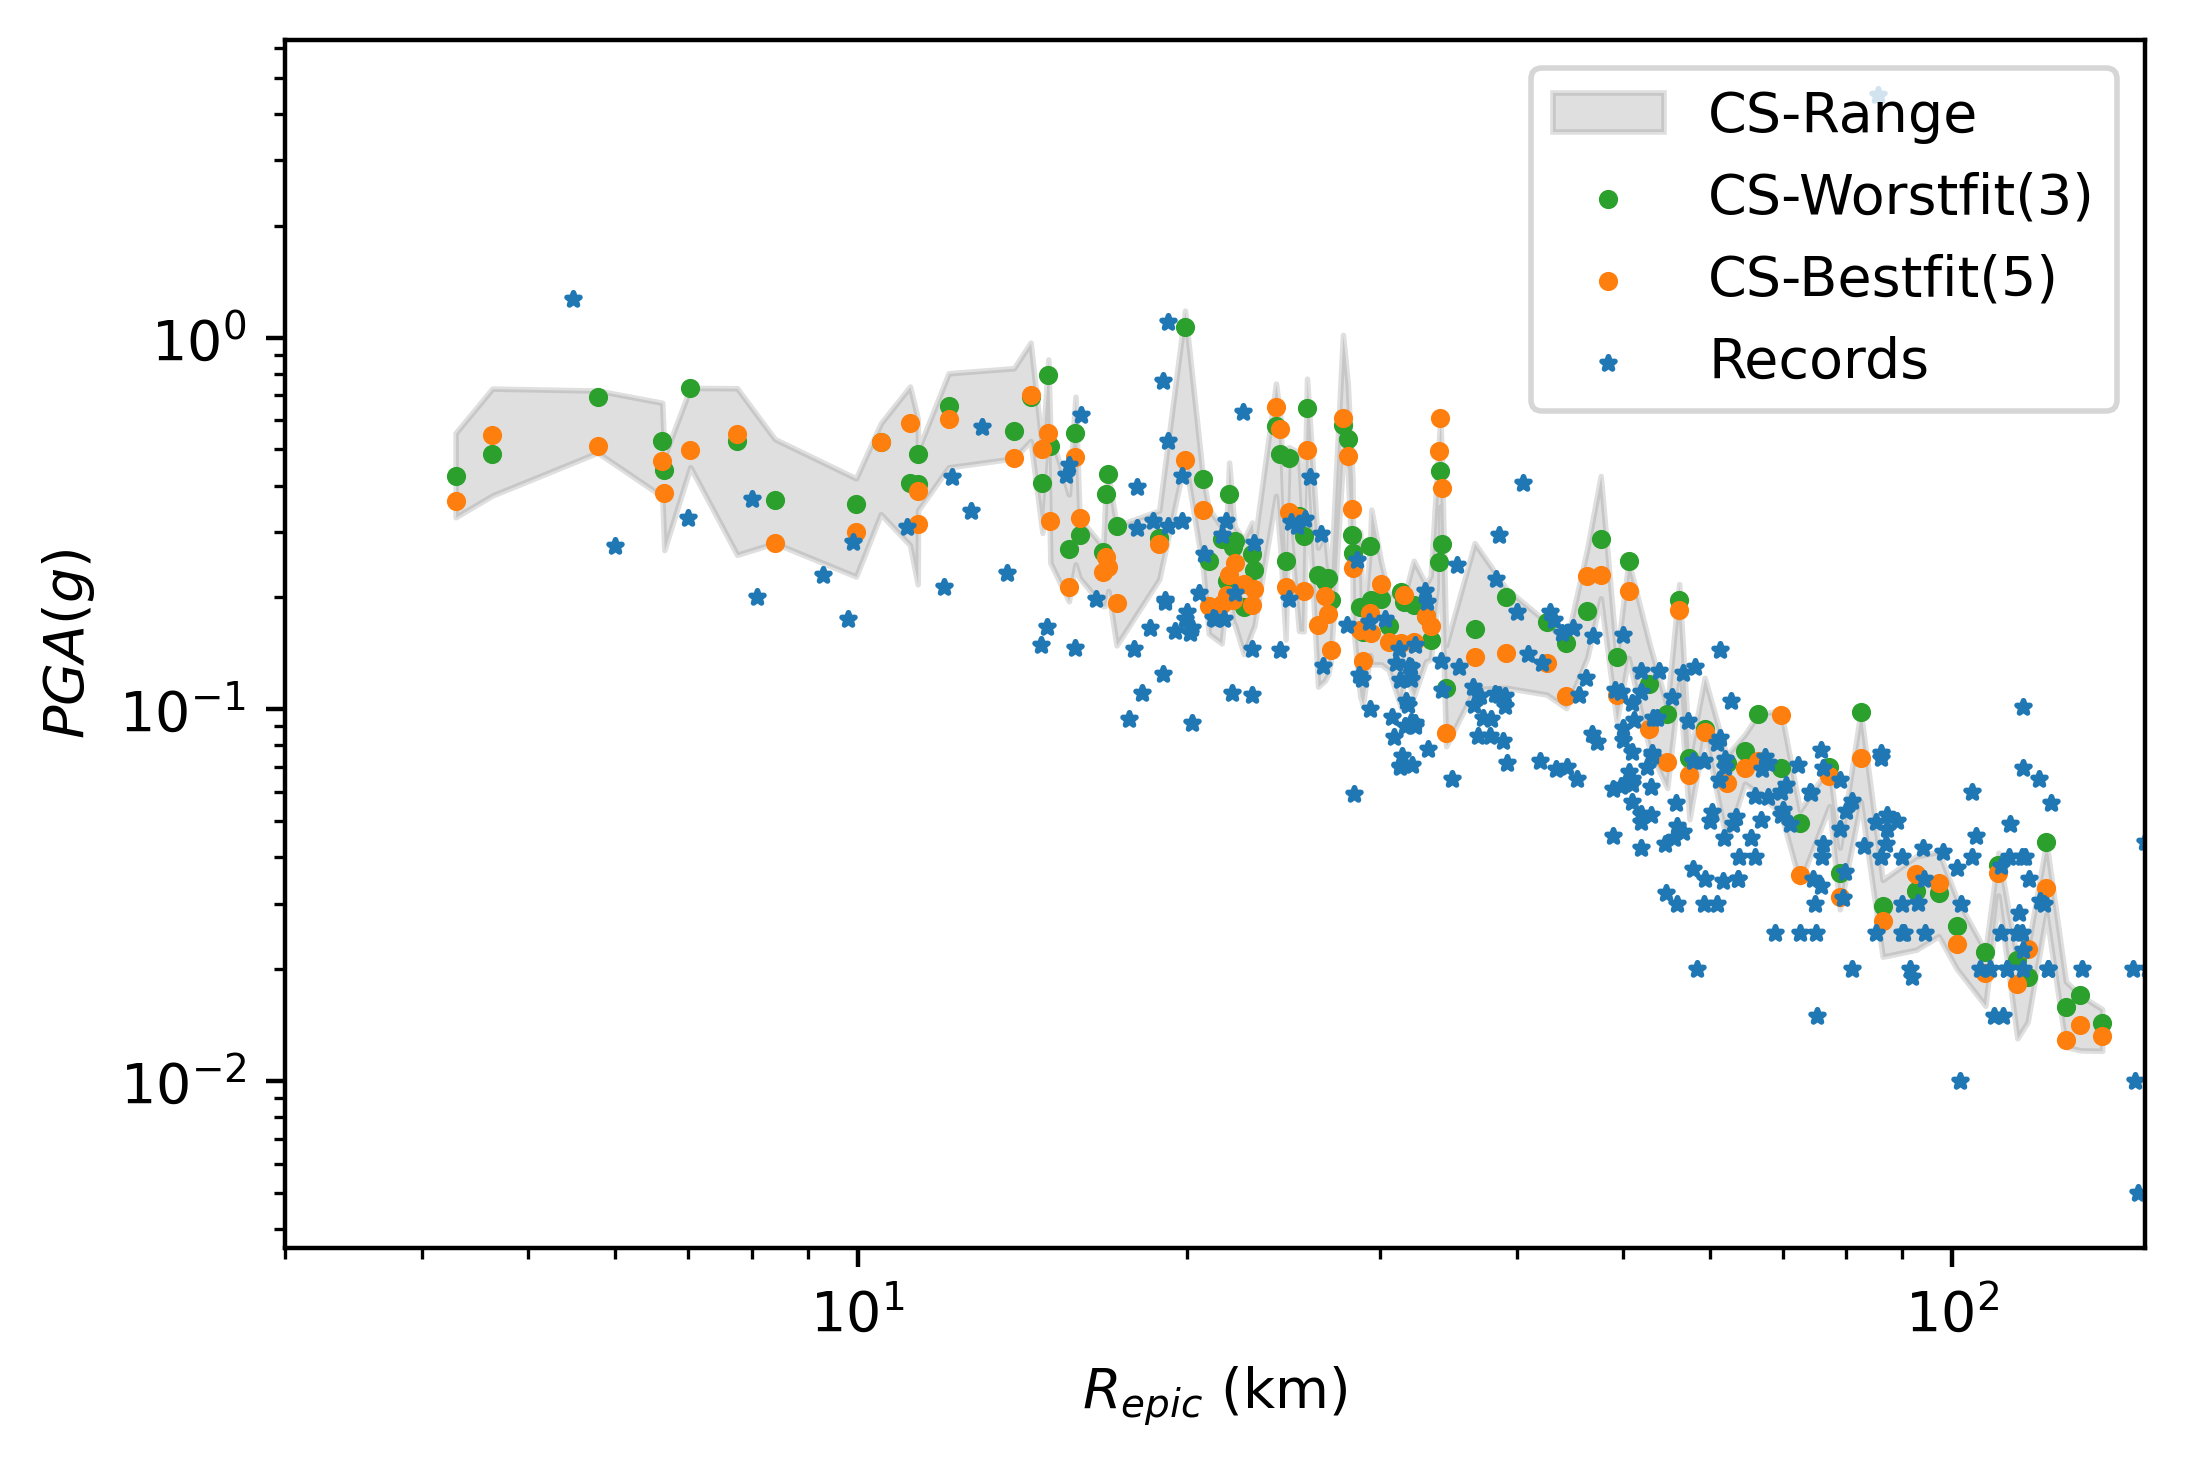

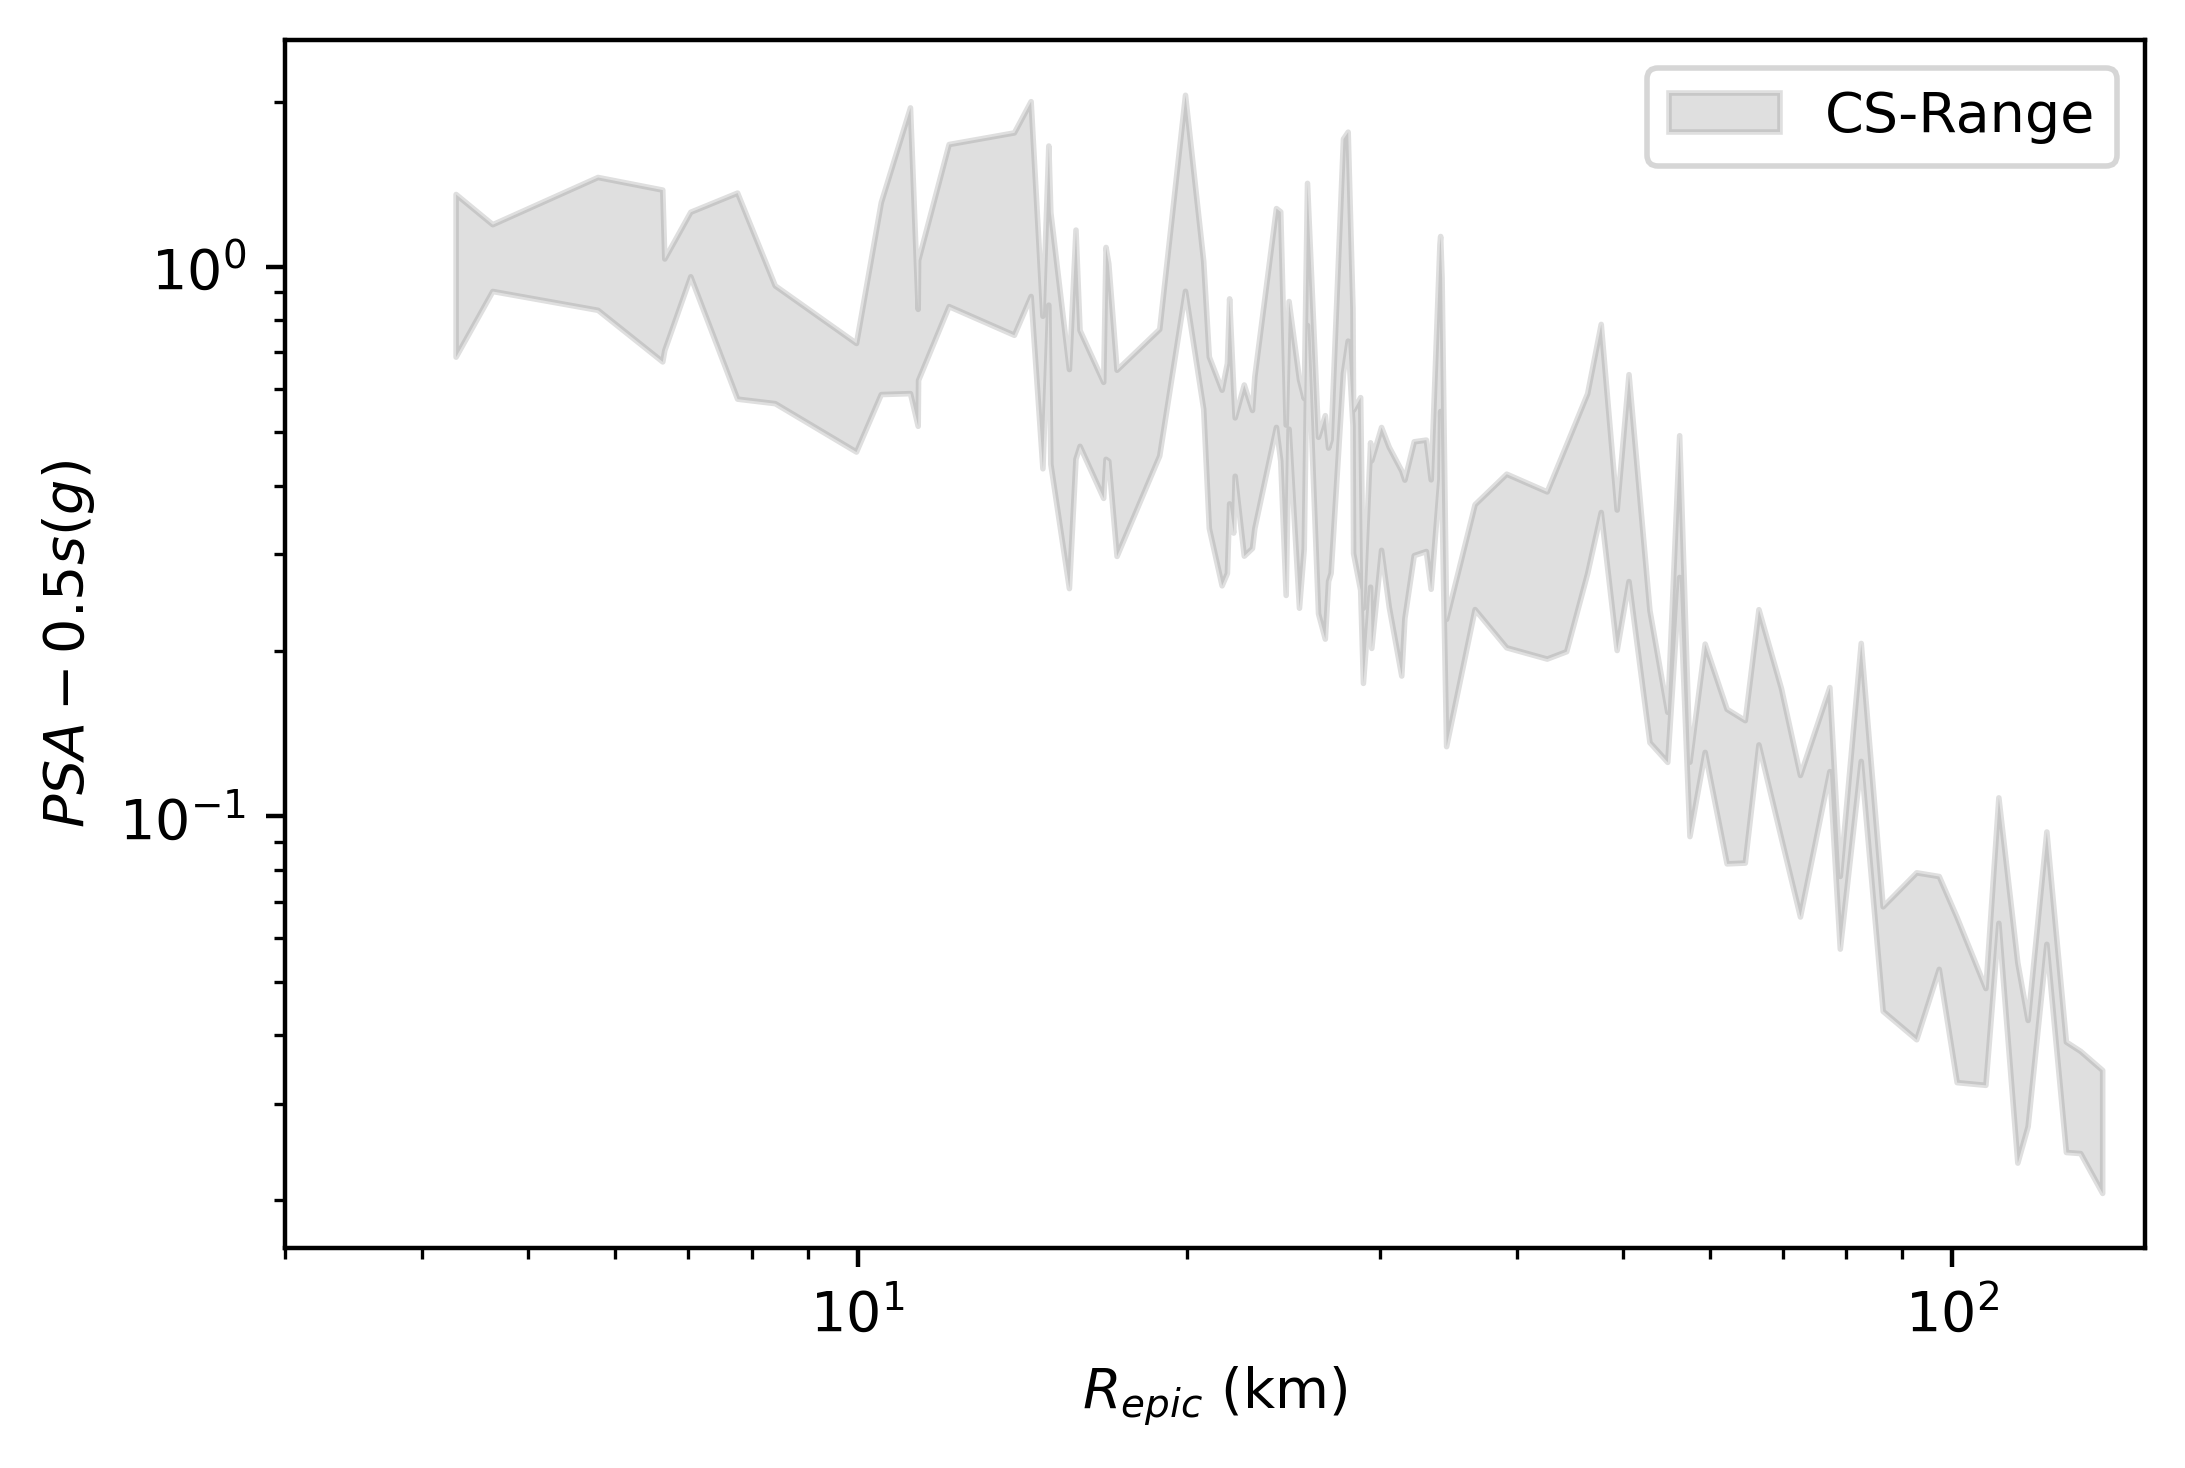

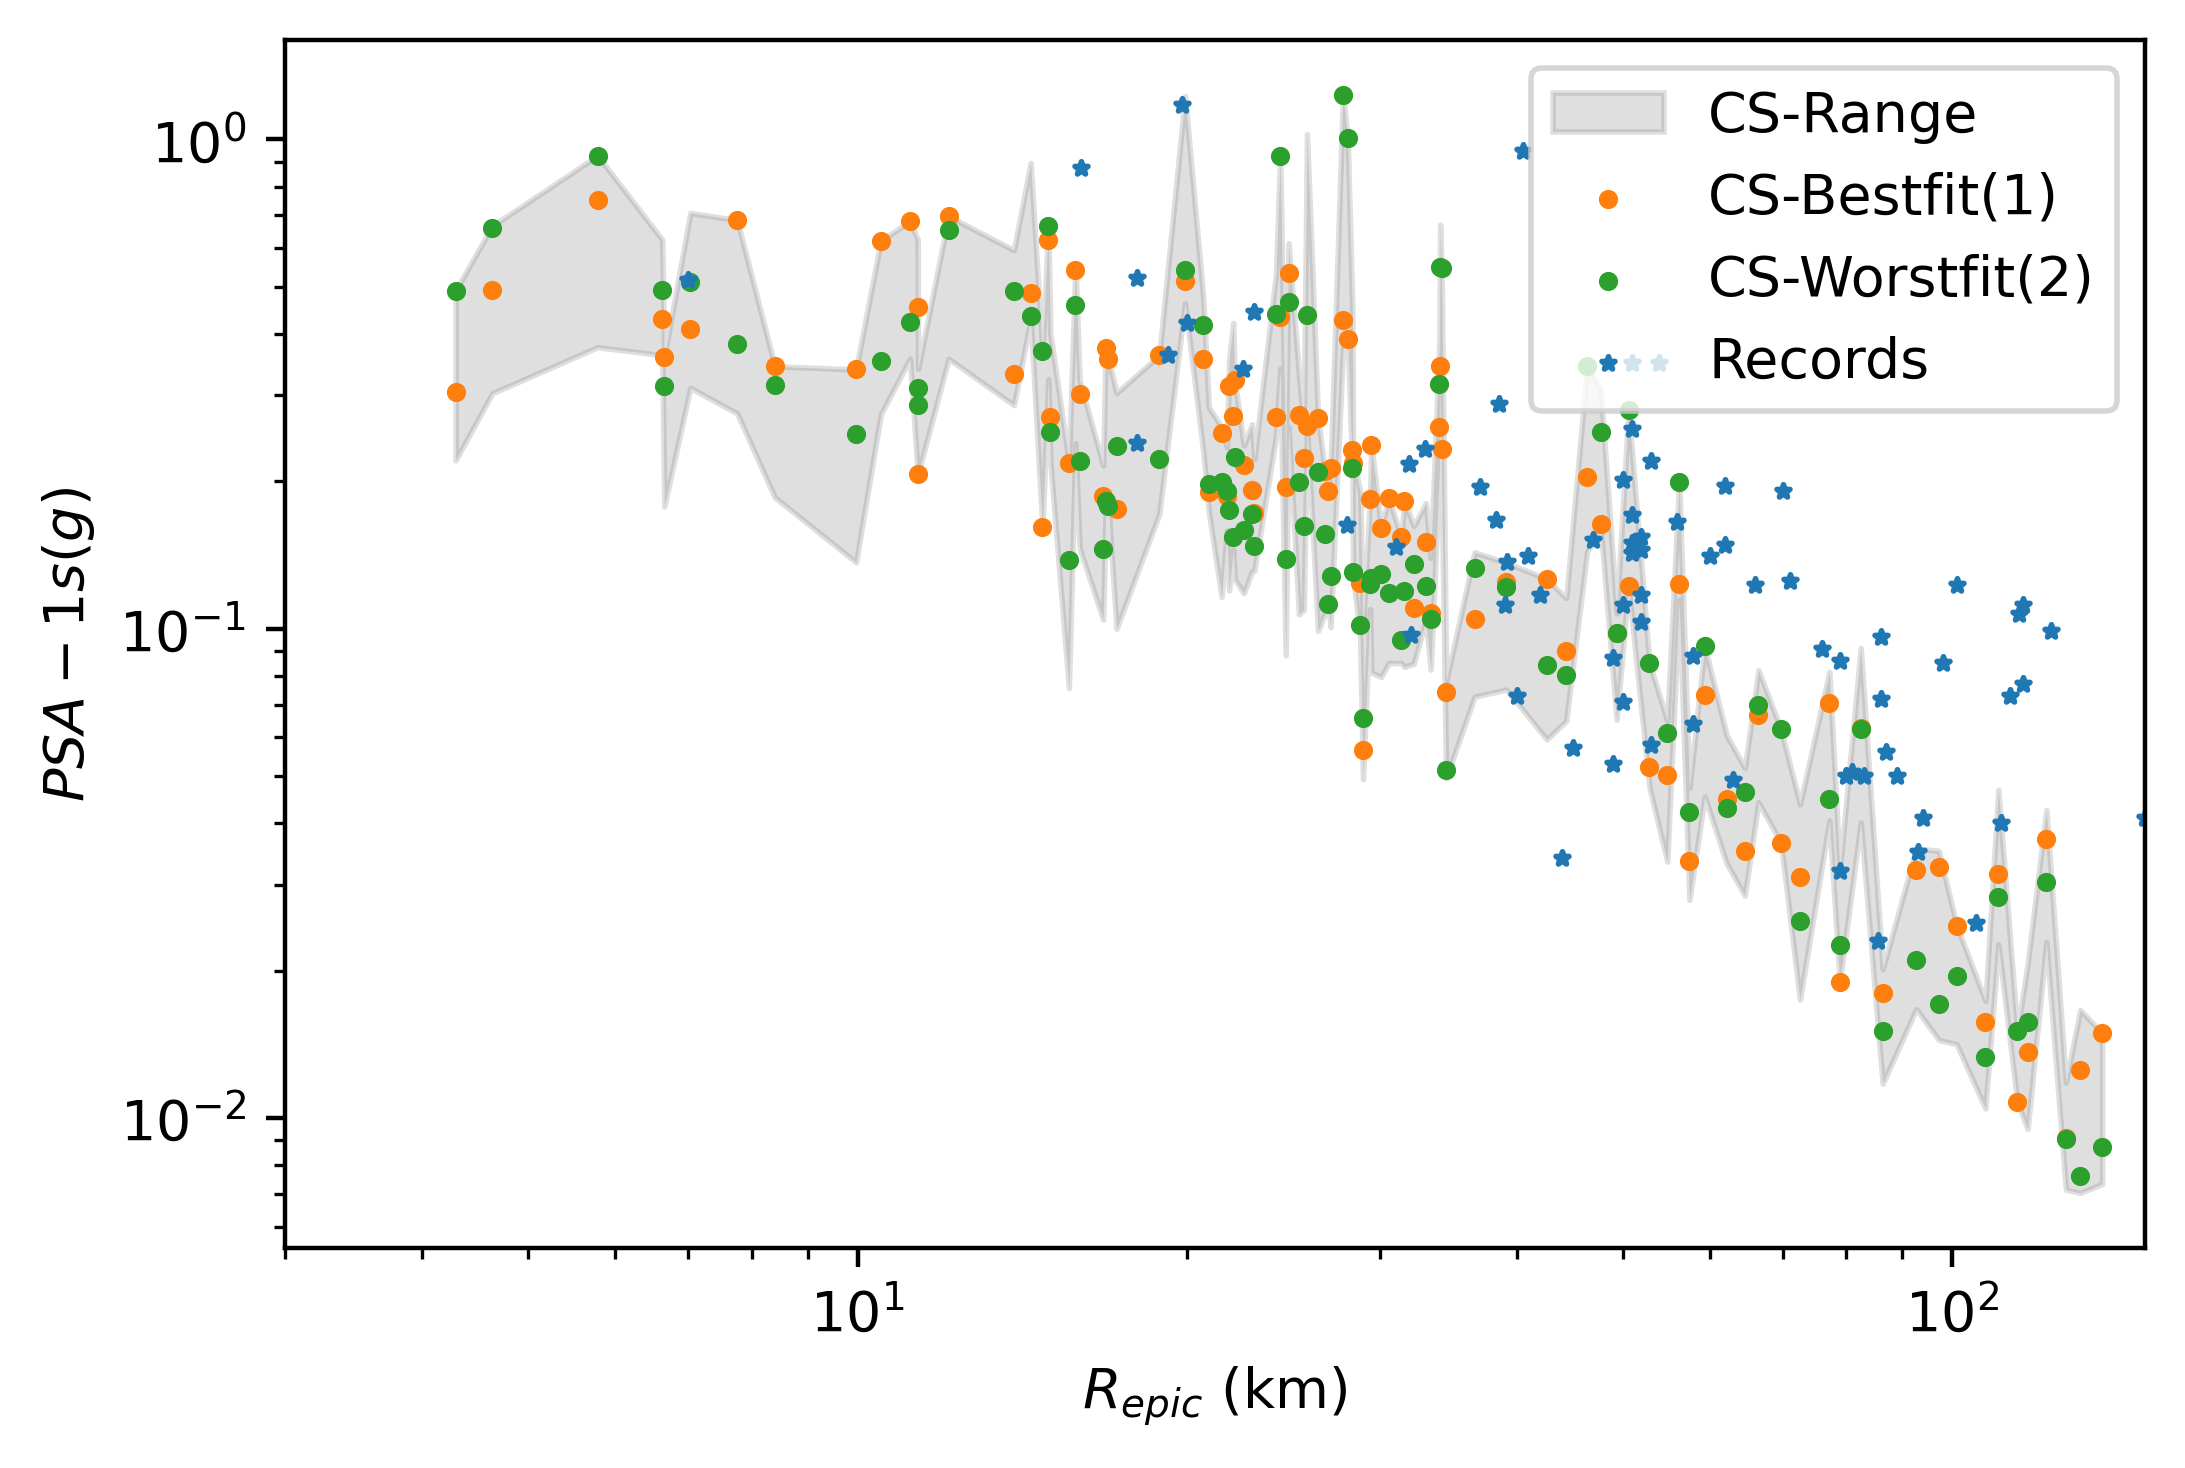

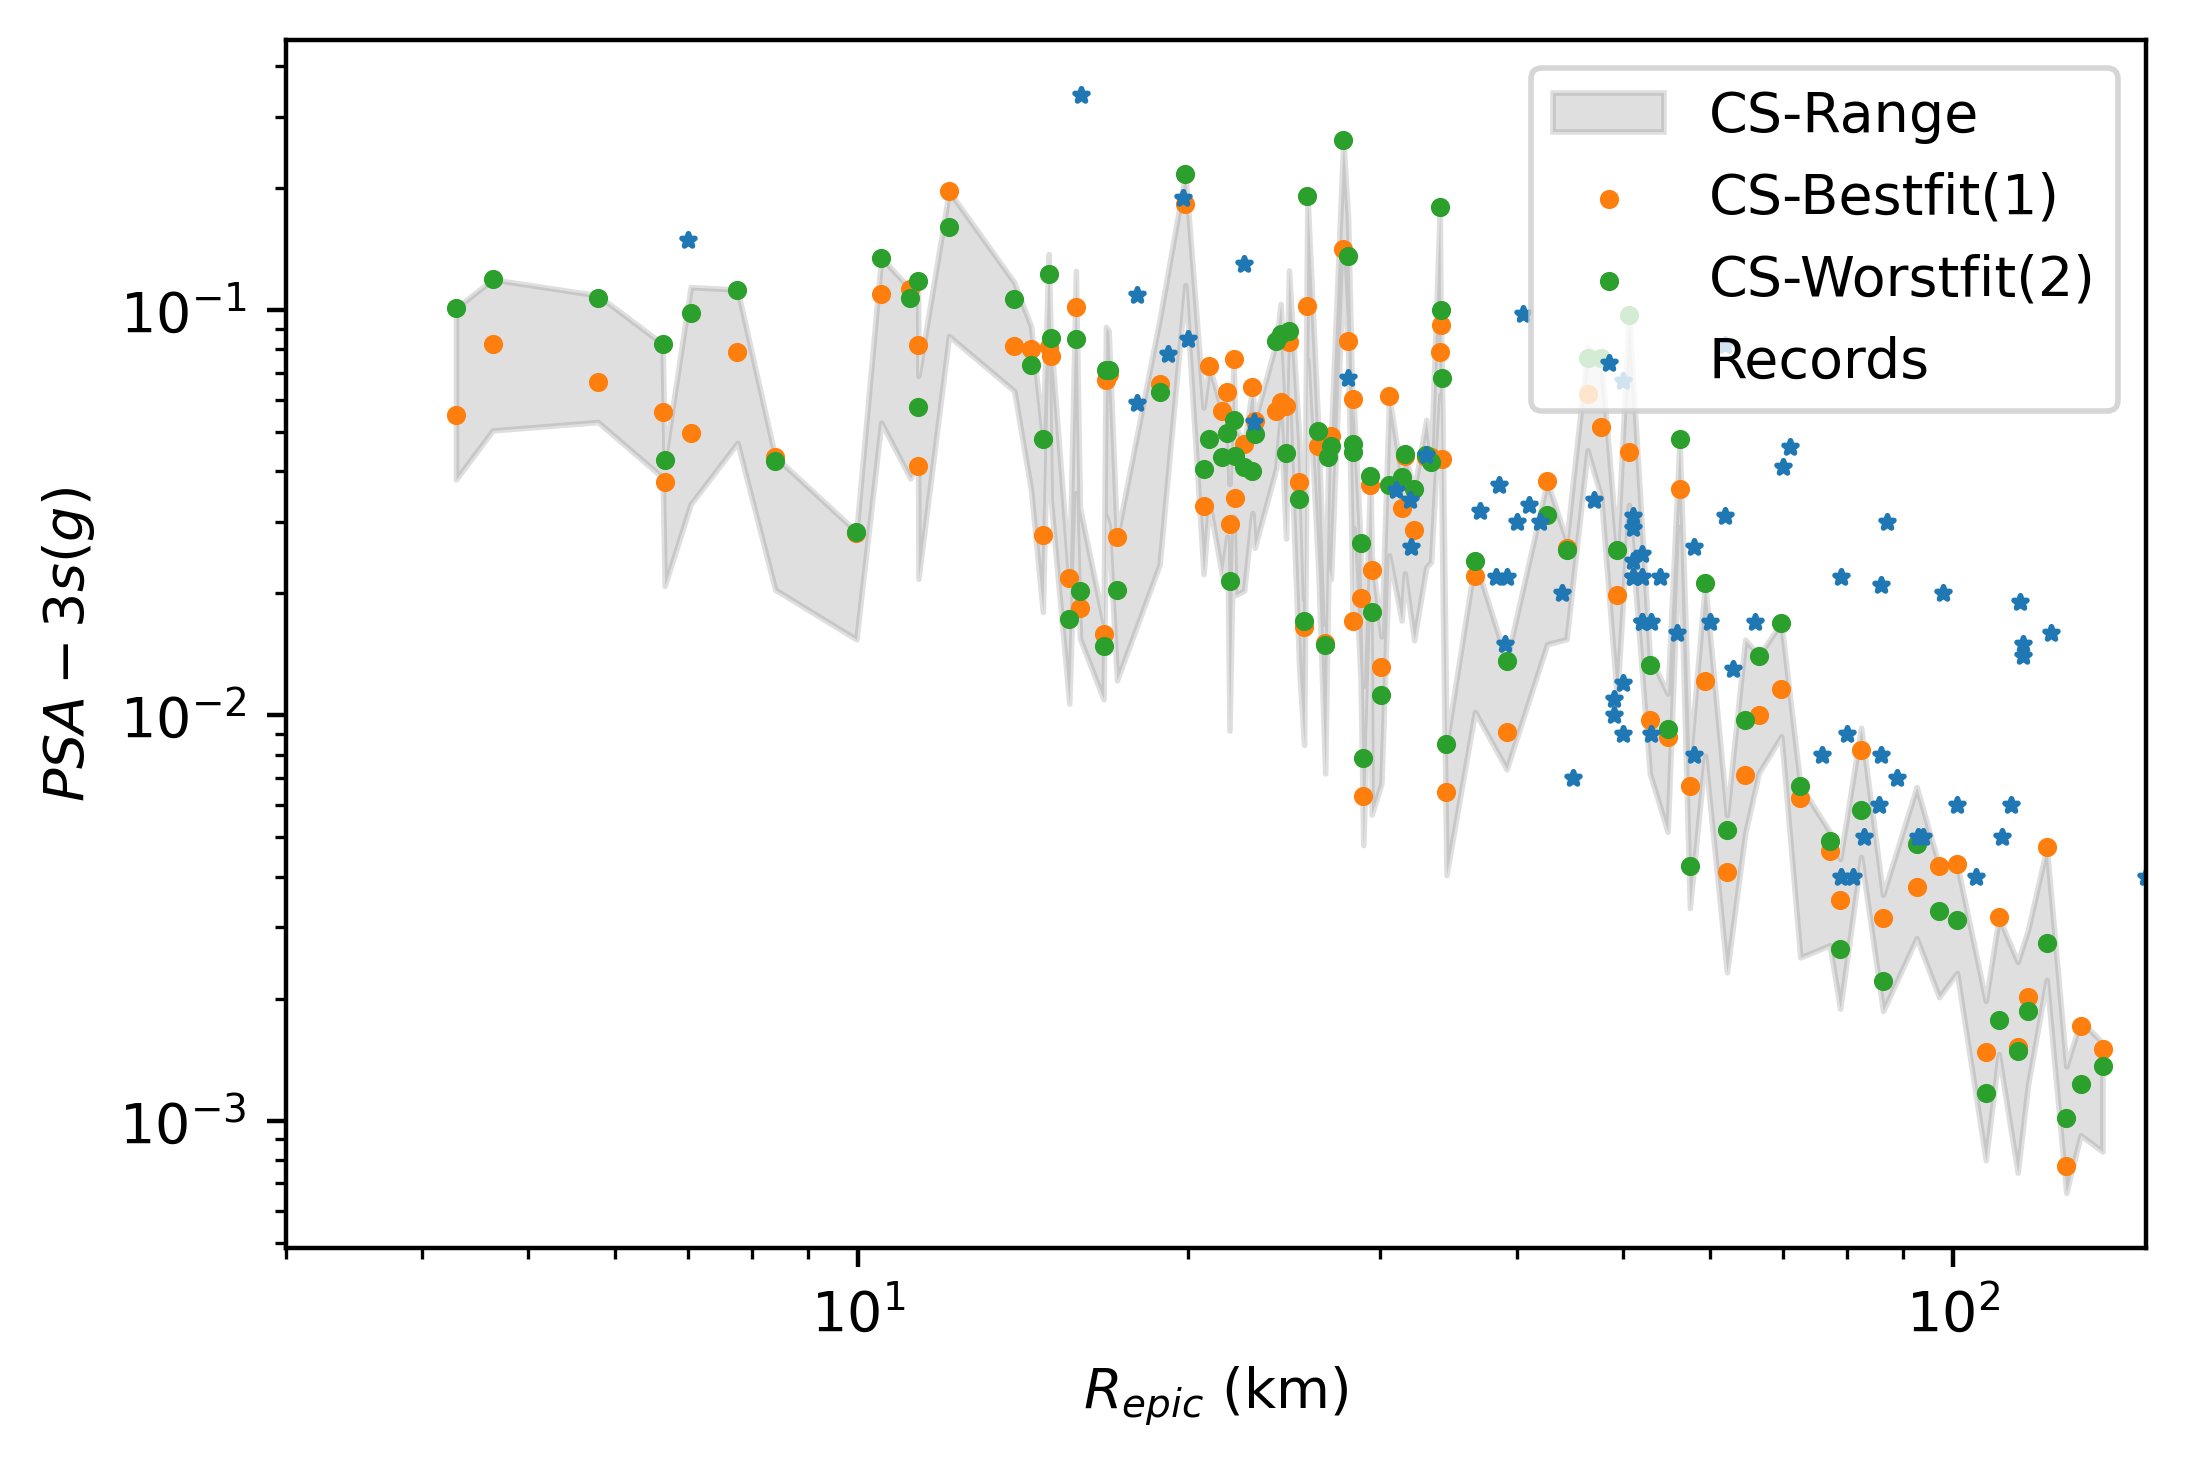

In [31]:
for metric in ['pgv', 'pga', 'psa05', 'psa10', 'psa30']:
    nr.plot_metric(metric=metric, save=True)

### Plot normalized difference

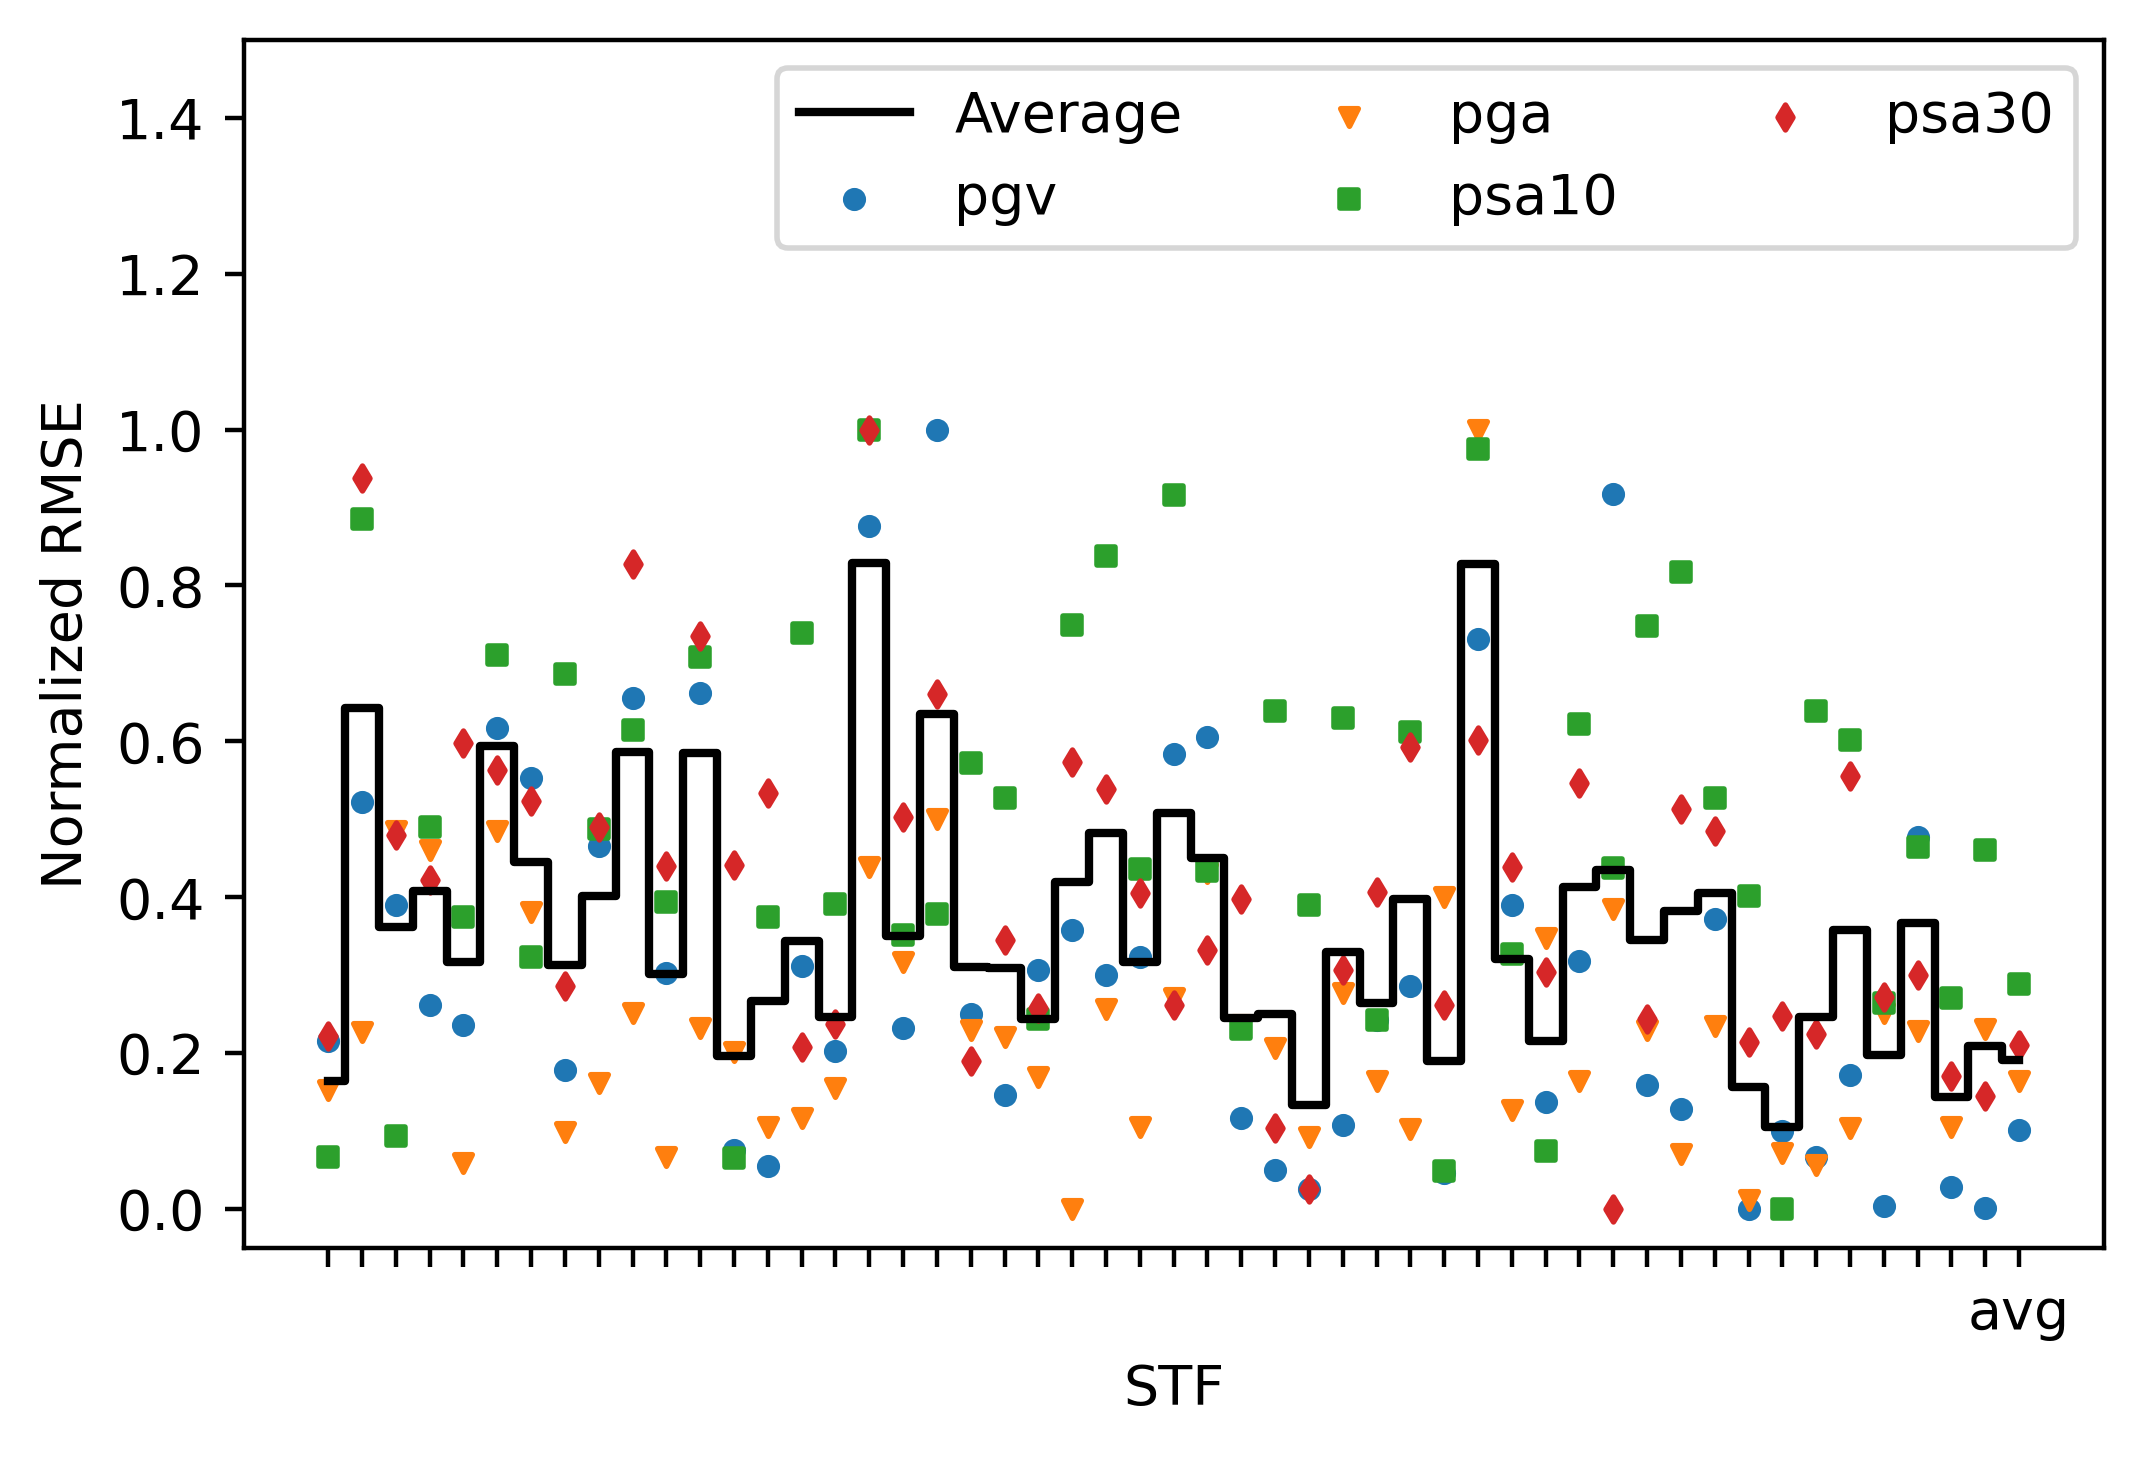

In [12]:
def plot_diff(save=False):
    colors = list(mcolors.TABLEAU_COLORS.keys())
    metrics = ['pgv', 'pga', 'psa10', 'psa30']
    markers = ['o', 'v', 's', 'd']
    norms = [0] * (len(nr.stf) + 1)
    fig, ax = plt.subplots(dpi=400)
    for i, metric in enumerate(metrics): 
        nr.prepare_cs_metric(metric)
        mean_misfit = np.mean([nr.misfit[k][metric] for k in range(len(nr.stf))])
        std_misfit = np.std([nr.misfit[k][metric] for k in range(len(nr.stf))])
        min_misfit = np.min([nr.misfit[k][metric] for k in range(len(nr.stf))])
        max_misfit = np.max([nr.misfit[k][metric] for k in range(len(nr.stf))])
        for j in range(len(nr.stf) + 1):  
            norm = (nr.misfit[j][metric] - min_misfit) / (max_misfit - min_misfit)
            norms[j] += norm

            ax.scatter(j, norm, marker=markers[i], c=colors[i], s=10,
                       label=f'{metric}' if j == 0 else None)
        
#     for j in range(len(nr.stf) + 1):
#         ax.hlines(norms[j] / len(metrics), xmin=j - 0.3, xmax = j + 0.3, 
#                   color='k', label='Average' if j == 0 else None)
    ax.plot(range(len(nr.stf) + 1), [n / len(metrics) for n in norms], color='k',
            drawstyle='steps-mid', label='Average')
    ax.set(xlabel='STF', xticks=np.arange(len(nr.stf) + 1), ylabel='Normalized RMSE')
    ax.set_xticklabels(["" and str(x) for x in range(len(nr.stf))] + ['avg'])
    ax.set_ylim(top=1.5)
    ax.legend(loc=1, ncol=3)
    if save:
        fig.savefig(f'CS_Data_norm_misfit.png', dpi=600, bbox_inches='tight', pad_inches=0.05)
    return norms
     
norms = plot_diff(save=True)

### Plot CS/Data ratio

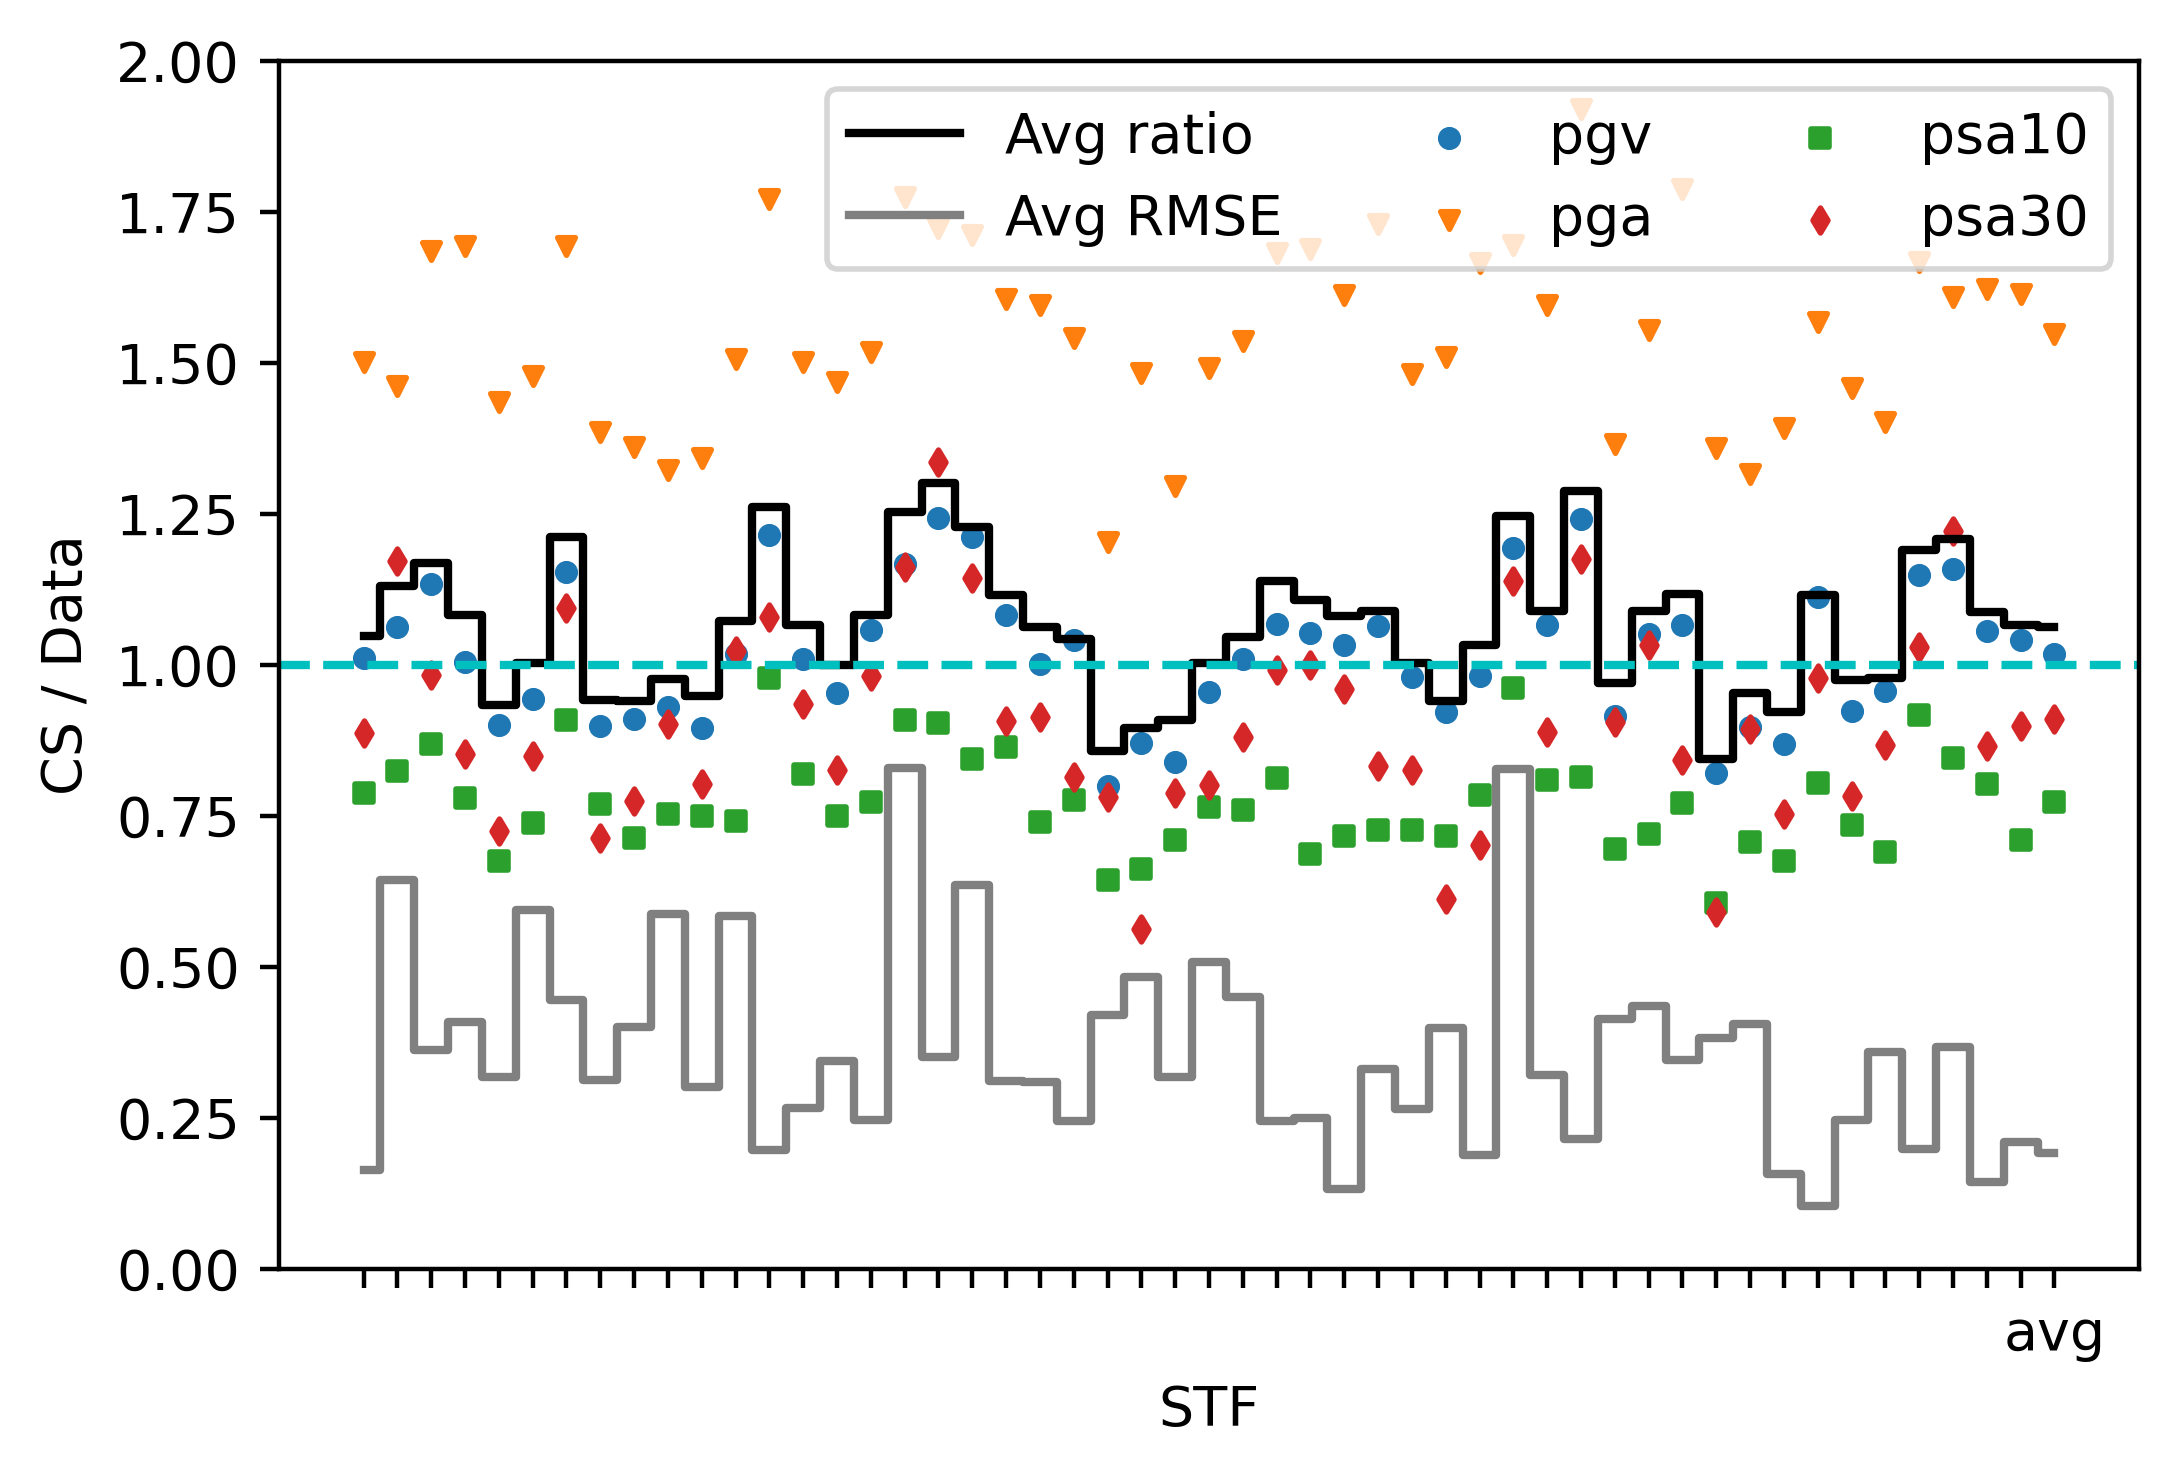

In [13]:
def plot_ratio(save=False):
    colors = list(mcolors.TABLEAU_COLORS.keys())
    metrics = ['pgv', 'pga', 'psa10', 'psa30']
    markers = ['o', 'v', 's', 'd']
    fig, ax = plt.subplots(dpi=400)
    avg_ratios = [0] * (len(nr.stf) + 1)
    for i, metric in enumerate(metrics):
        nr.prepare_cs_metric(metric)
        for j in range(len(nr.stf) + 1):
            ax.scatter(j, nr.metric_ratio[j][metric], marker=markers[i], c=colors[i], s=10,
                       label=f'{metric}' if j == 0 else None)
            avg_ratios[j] += nr.metric_ratio[j][metric]
        
#     for j in range(len(nr.stf) + 1): 
#         avg_ratio = np.mean([nr.metric_ratio[j][metric] for metric in metrics])
#         ax.hlines(avg_ratio, xmin=j - 0.3, xmax = j + 0.3, color='k',
#                    label='Average' if j == 0 else None)
    ax.plot(range(len(nr.stf) + 1), [r / len(metrics) for r in avg_ratios], color='k',
            drawstyle='steps-mid', label='Avg ratio')
    ax.plot(range(len(nr.stf) + 1), [n / len(metrics) for n in norms], color='gray',
            drawstyle='steps-mid', label='Avg RMSE')
    ax.axhline(1, linestyle='--', color='c')
    ax.set(xlabel='STF', xticks=np.arange(len(nr.stf) + 1), ylabel='CS / Data', ylim=(0, 2))
    ax.set_xticklabels(["" and str(x) for x in range(len(nr.stf))] + ['avg'])
    ax.legend(loc=1, ncol=3)
    if save:
        fig.savefig(f'CS_Data_ratio.png', dpi=600, bbox_inches='tight', pad_inches=0.05)
    return avg_ratios
   
avg_ratios = plot_ratio(save=True)

In [199]:
print(nr.stf)
s = nr.stf[0]
print(s.sites[0][0])
s.prepare_shakemap()

{0: <__main__.STF object at 0x7fde19788c50>, 1: <__main__.STF object at 0x7fde19788d50>, 2: <__main__.STF object at 0x7fde197c14d0>, 3: <__main__.STF object at 0x7fde197bce50>, 4: <__main__.STF object at 0x7fde1cb70210>, 5: <__main__.STF object at 0x7fde23301ad0>, 6: <__main__.STF object at 0x7fde2c455e10>, 7: <__main__.STF object at 0x7fde2c4742d0>, 8: <__main__.STF object at 0x7fde2c474ad0>, 9: <__main__.STF object at 0x7fde2c4f44d0>}
ACTN
['ACTN', '-118.18378', '34.4613', '4296']


TypeError: unsupported format string passed to numpy.ndarray.__format__

### Prepare Kevin's code

In [10]:
with open('tomac_for_Kevin.sh','w') as fid, \
     open('run_Kevin.sh','w') as fid2:
    for p, metric in zip([-1, 0, 0.5, 1, 3], ['pgv', 'pga', 'psa05', 'psa10', 'psa30']):
        # avg plots, using the nearest scenario's src_id/rup_id/rup_var_id
        if metric != 'psa05':
            text = f'tomac.sh -p -d /Users/zhh076/work/ShakeMap/CyberShake records_{metric}.txt\n'
            fid.write(text)
            text = f'echo "$(awk \'{{if($1 < 0) {{t = $1; $1 = $2; $2=t}}; print}}\' '\
                   f'records_{metric}.txt)" > records_{metric}.txt;\n' \
                   f'java -Xmx2G -cp opensha-cybershake-all.jar ' \
                   f'org.opensha.sha.cybershake.maps.CyberShakeScenarioShakeMapGenerator ' \
                   f'--study STUDY_15_12 --period {p} --source-id {nr.events[0][0]} --rupture-id {nr.events[0][1]} ' \
                   f'--intensity-file records_{metric}.txt ' \
                   f'--spacing 0.005 --colorbar-min {nr.metric_min[metric]} --colorbar-max {nr.metric_max[metric]} ' \
                   f'-o /Users/zhh076/work/ShakeMap/CyberShake/records;\n'
            fid2.write(text)
        
        text = f'tomac.sh -p -d /Users/zhh076/work/ShakeMap/CyberShake avg_{metric}.txt\n'
        fid.write(text)
        text = f'echo "$(awk \'{{if($1 < 0) {{t = $1; $1 = $2; $2=t}}; print}}\' '\
               f'avg_{metric}.txt)" > avg_{metric}.txt;\n' \
               f'java -Xmx2G -cp opensha-cybershake-all.jar ' \
               f'org.opensha.sha.cybershake.maps.CyberShakeScenarioShakeMapGenerator ' \
               f'--study STUDY_15_12 --period {p} --source-id {nr.events[0][0]} --rupture-id {nr.events[0][1]} ' \
               f'--intensity-file avg_{metric}.txt ' \
               f'--spacing 0.005 --colorbar-min {nr.metric_min[metric]} --colorbar-max {nr.metric_max[metric]} ' \
               f'-o /Users/zhh076/work/ShakeMap/CyberShake/;\n'
        fid2.write(text)
        
        for s in nr.events:         
            text = f'tomac.sh -p -d /Users/zhh076/work/ShakeMap/CyberShake/{s[0]}_' \
                  f'{s[1]}_{s[2]}_uniform {s[0]}_{s[1]}_{s[2]}_uniform_{metric}.txt\n'
            fid.write(text)
            text = f'cd {s[0]}_{s[1]}_{s[2]}_uniform;\n' \
                   f'echo "$(awk \'{{if($1 < 0) {{t = $1; $1 = $2; $2=t}}; print}}\' {s[0]}_{s[1]}_{s[2]}_uniform_{metric}.txt)" '\
                   f'> {s[0]}_{s[1]}_{s[2]}_uniform_{metric}.txt;\n' \
                   f'java -Xmx2G -cp ../opensha-cybershake-all.jar ' \
                   f'org.opensha.sha.cybershake.maps.CyberShakeScenarioShakeMapGenerator ' \
                   f'--study STUDY_15_12 --period {p} --source-id {s[0]} --rupture-id {s[1]} ' \
                   f'--rupture-var-id {s[2]} --intensity-file {s[0]}_{s[1]}_{s[2]}_uniform_{metric}.txt ' \
                   f'--spacing 0.005 --colorbar-min {nr.metric_min[metric]} --colorbar-max {nr.metric_max[metric]} ' \
                   f'-o /Users/zhh076/work/ShakeMap/CyberShake/{s[0]}_{s[1]}_{s[2]}_uniform;\n' \
                   f'cd ..;\n'
            fid2.write(text)            
    fid.write('tomac.sh -p -d /Users/zhh076/work/ShakeMap/CyberShake run_Kevin.sh')

# !!This doesn't work
# call_sub('bash tomac_for_Kevin.sh', shell=True)
            

In [114]:
p = call_sub('ls -l', shell=True)
print(1 if p.stderr else 0)

0


In [48]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
client = Client("IRIS")

In [49]:
starttime = UTCDateTime(1994, 1, 17, 12, 30, 30)
endtime = UTCDateTime(1994, 1, 17, 12, 30, 59)
cat = client.get_events(starttime=starttime, endtime=endtime,minmagnitude=6.6, catalog="ISC")
print(cat) 

1 Event(s) in Catalog:
1994-01-17T12:30:54.620000Z | +34.136, -118.583 | 6.7 mw


In [50]:
inventory = client.get_stations(network="IU", starttime=starttime, latitude=34.136, longitude=-118.583, maxradius=100)
print(inventory)

Inventory created at 2020-04-01T08:46:17.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?starttime=1994-01-17...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (203):
			IU.ADK (Adak, Aleutian Islands, Alaska) (3x)
			IU.AFI (Afiamalu, Samoa) (3x)
			IU.ANMO (Albuquerque, New Mexico, USA) (6x)
			IU.BBSR (Bermuda Institute of Ocean Sciences, St George's Bermuda) (2x)
			IU.BILL (Bilibino, Russia) (4x)
			IU.BOCO (Bogota, Colombia) (2x)
			IU.CCM (Cathedral Cave, Missouri, USA) (3x)
			IU.COL (College Outpost, Alaska, USA) (2x)
			IU.COLA (College Outpost, Alaska, USA) (2x)
			IU.COR (Corvallis, Oregon, USA) (3x)
			IU.DWPF (Disney Wilderness Preserve, Florida, USA) (3x)
			IU.FUNA (Funafuti, Tuvalu) (3x)
			IU.GRFO (Grafenberg, Germany) (4x)
			IU.GUMO (Guam, Mariana Islands) (4x)
			IU.HKT (Hockley, Texas) (4x)
			IU.HNR (Honiara, Solomon Islands) (4x)
			IU.HRV (Adam Dz

In [52]:
st = client.get_waveforms("CGS", "s795", "*", "BH?", starttime, starttime+100,attach_response=True)
st.remove_response(output="VEL") 
st.plot()  

FDSNException: Bad request. If you think your request was valid please contact the developers.
Detailed response of server:

Error 400: Unrecognized network code [1-2 characters]: 'CGS'
More Details:
handler exited, code: 3  reason: Bad Request
Request:
http://service.iris.edu/fdsnws/dataselect/1/query?starttime=1994-01-17T12%3A30%3A30.000000&endtime=1994-01-17T12%3A32%3A10.000000&network=CGS&station=s795&location=%2A&channel=BH%3F
Request Submitted:
2020/04/01 08:46:34 UTC
Service version:
Service: fdsnws-dataselect  version: 1.1.9